In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import logging
import pypsa
import os.path
import sys

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd

# from make_summary import assign_carriers
from _helpers import configure_logging, mock_snakemake
from plot_summary import rename_techs
from constants import PLOT_COST_UNITS, PLOT_CAP_UNITS,PLOT_SUPPLY_UNITS
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
from plot_network import plot_capex_map, plot_map
from _plot_utilities import fix_network_names_colors
logger = logging.getLogger(__name__)


In [4]:

snakemake = mock_snakemake(
    "plot_network",
    snakefile_path=os.path.abspath("../"),
    opts="ll",
    topology="current+Neighbor",
    pathway="exponential175",
    planning_horizons="2060",
    heating_demand="positive",
)

configure_logging(snakemake, logger=logger)
config = snakemake.config
tech_colors = config["plotting"]["tech_colors"]

# n = pypsa.Network(snakemake.input.network)
# ntw_path = "/home/ivanra/documents/PyPSA-China-PIK/results/version-0325.175.1H/postnetworks/positive/postnetwork-ll-current+Neighbor-exponential175-2020.nc"
ntw_path = "/home/ivanra/downloads/PaperResultsXiaowei_networks/postnetwork-ll-current+Neighbor-exponential175-2060.nc"
n = pypsa.Network(ntw_path)


RULES None

RULES None


INFO:pypsa.io:Imported network postnetwork-ll-current+Neighbor-exponential175-2060.nc has buses, carriers, generators, global_constraints, links, loads, storage_units, stores


In [5]:
fix_network_names_colors(n, config)

/home/ivanra/documents/PyPSA-China-PIK/workflow/scripts/_plot_utilities.py:90: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [6]:
n.add("Carrier", "AC")
if config["add_hydro"]:
    n.add("Carrier", "stations")
    n.add("Carrier", "hydro_inflow")

## post fixes
- due to not doing this earlier

In [7]:
# read nice names, add missing
nice_names = config["plotting"]["nice_names"]
missing_names = n.carriers.index.difference(nice_names)
nice_names.update(dict(zip(missing_names, missing_names)))

# add nice_names
n.carriers.nice_name = n.carriers.index.map(nice_names)
# map colors
t_colors = snakemake.config["plotting"]["tech_colors"]
n.carriers.color = n.carriers.index.map(t_colors)
NAN_COLOR = "lightgrey"
n.carriers.color.fillna(NAN_COLOR, inplace=True)

/tmp/ipykernel_12268/1103123909.py:12: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





# plot map

In [8]:
from plot_network import plot_capex_map, plot_map

## plot capex

/home/ivanra/miniconda3/envs/pypsa-china/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".

/home/ivanra/miniconda3/envs/pypsa-china/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".

/home/ivanra/documents/PyPSA-China-PIK/workflow/scripts/plot_network.py:128: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/home/ivanra/documents/PyPSA-China-PIK/workflow/scripts/plot_network.py:335: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



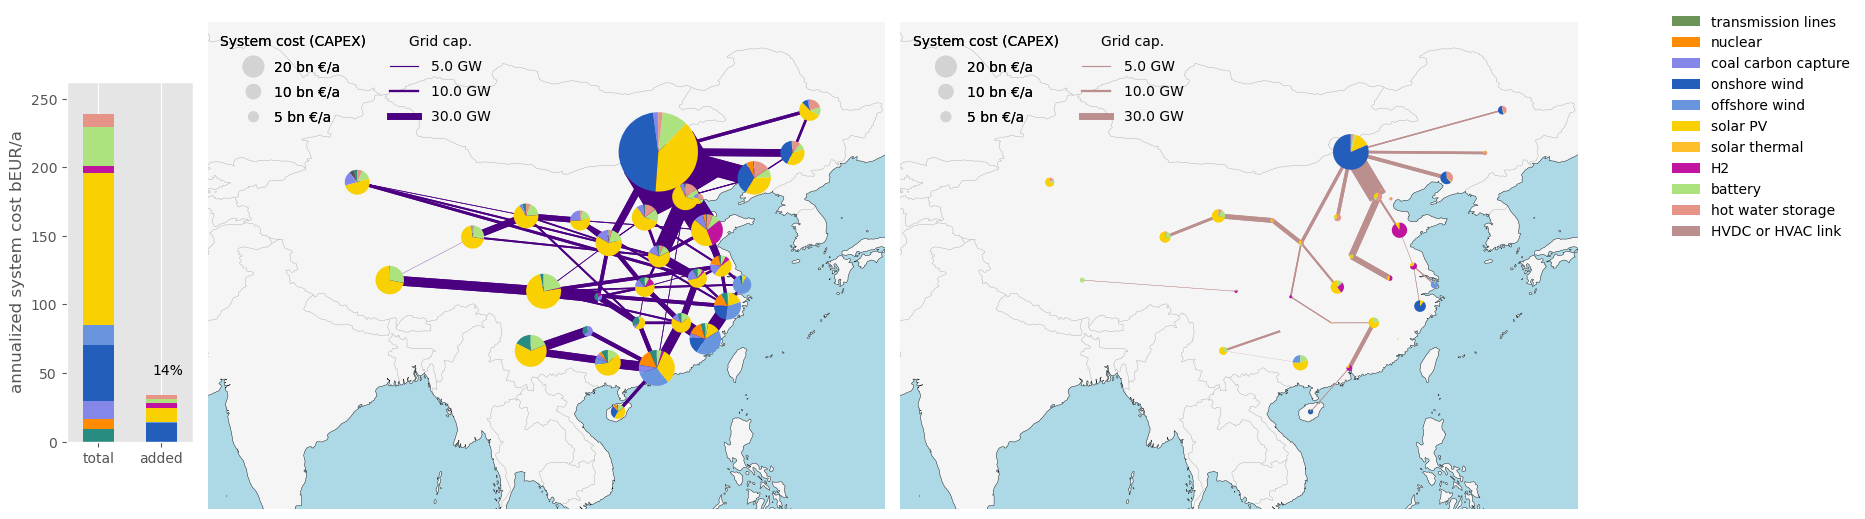

In [9]:
ax = plot_capex_map(n, 2060, snakemake.config["costs"]["discountrate"], config["plotting"])

In [10]:
from _plot_utilities import assign_location
from plot_network import plot_map
opts = config["plotting"]
plot_ntwk = n.copy()
assign_location(plot_ntwk)
cpx = plot_ntwk.statistics.capex(groupby=pypsa.statistics.get_bus_and_carrier)
cpx2 = cpx.droplevel(0)

In [11]:
anhui_stats = cpx.unstack().groupby(level=1).sum().loc["Anhui"]
anhui_stats.index = anhui_stats.index.map(rename_techs)
anhui_stats.where(anhui_stats > 0).dropna().sort_index()

carrier
Battery Storage         4.561884e+08
Heat Pump               7.186157e+08
Hydrogen Storage        7.149554e+03
Onshore Wind            2.823696e+03
Pumped Hydro Storage    2.701888e+08
Solar                   4.723609e+09
coal                    1.665203e+09
hydroelectricity        3.680158e+08
resistive heater        4.571001e+07
transmission lines      4.118761e+09
Name: Anhui, dtype: float64

In [12]:
from _helpers import calc_component_capex
from _plot_utilities import assign_location
from plot_network import make_cost_pies
costs_add = pd.DataFrame(index=n.buses.index)
costs_nom = pd.DataFrame(index=n.buses.index)
plot_ntwk = n.copy()
# Drop non-electric buses so they don't clutter the plot
plot_ntwk.buses.drop(plot_ntwk.buses.index[plot_ntwk.buses.carrier != "AC"], inplace=True)

assign_location(plot_ntwk)
for comp in plot_ntwk.iterate_components():
    # df_c = getattr(ntwk, comp)
    print(comp.name, comp.list_name)
    df_c = comp.df

    if df_c.empty:
        continue
    if not "capital_cost" in df_c.columns:
        continue

    df_c["nice_group"] = comp.name + "_" + df_c.carrier #.map(rename_techs)

    cap_name = "e_nom_opt" if comp.list_name == "stores" else "p_nom_opt"
    cap_before_ext = "e_nom" if comp.list_name == "stores" else "p_nom"

    costs_total = calc_component_capex(df_c, cap_name)
    costs_before_ext = calc_component_capex(df_c, cap_before_ext)
    costs_diff = costs_total - costs_before_ext

    costs_add = pd.concat([costs_add, costs_diff], axis=1)
    costs_nom = pd.concat([costs_nom, costs_total], axis=1)

costs_pathway = costs_add
cost_pie = make_cost_pies(plot_ntwk, costs_pathway, tech_colors)
cost_pie_nom = make_cost_pies(plot_ntwk, costs_nom, tech_colors)

       'Generator_onwind', 'Generator_solar', 'Generator_solar thermal',
       'Link_AC', 'Link_CHP coal', 'Link_CHP gas', 'Link_CO2 capture',
       'Link_H2', 'Link_H2 CHP', 'Link_OCGT gas', 'Link_Sabatier',
       'Link_battery', 'Link_biomass', 'Link_coal boiler', 'Link_gas boiler',
       'Link_heat pump', 'Link_resistive heater', 'Store_H2', 'Store_battery',
       'Store_water tanks'],
      dtype='object')
       'Generator_hydroelectricity', 'Generator_nuclear', 'Generator_offwind',
       'Generator_onwind', 'Generator_solar', 'Generator_solar thermal',
       'Link_AC', 'Link_CHP coal', 'Link_CHP gas', 'Link_CO2 capture',
       'Link_H2', 'Link_H2 CHP', 'Link_OCGT gas', 'Link_Sabatier',
       'Link_battery', 'Link_biomass', 'Link_coal boiler', 'Link_gas boiler',
       'Link_heat pump', 'Link_hydroelectricity', 'Link_resistive heater',
       'StorageUnit_PHS', 'Store_H2', 'Store_battery', 'Store_water tanks'],
      dtype='object')


LineType line_types
TransformerType transformer_types
Link links
Carrier carriers
Generator generators
Load loads
StorageUnit storage_units
Bus buses
GlobalConstraint global_constraints
Store stores


In [13]:
costs_nom.loc["Anhui"]

Link_AC                       0.000000e+00
Link_CHP coal                 4.631689e+03
Link_CHP gas                  1.031874e+04
Link_CO2 capture              6.220741e+08
Link_H2                       7.149554e+03
Link_H2 CHP                   4.945211e+08
Link_OCGT gas                 5.580432e+08
Link_Sabatier                 1.612604e+03
Link_battery                  4.561884e+08
Link_battery discharger       0.000000e+00
Link_biomass                  8.723083e+08
Link_coal boiler              9.907324e+07
Link_gas boiler               2.630876e+07
Link_heat pump                7.186157e+08
Link_hydroelectricity         0.000000e+00
Link_resistive heater         4.571001e+07
Link_stations                 0.000000e+00
Link_water tanks              0.000000e+00
Generator_coal                0.000000e+00
Generator_coal cc             1.665203e+09
Generator_coal power plant    0.000000e+00
Generator_gas                 0.000000e+00
Generator_hydro_inflow        0.000000e+00
Generator_h

In [14]:
costs_nom.loc["Anhui"].where(costs_nom.loc["Anhui"] > 0).dropna().sort_index()

Generator_coal cc             1.665203e+09
Generator_hydroelectricity    3.680158e+08
Generator_onwind              2.823696e+03
Generator_solar               4.723609e+09
Generator_solar thermal       1.498136e+03
Link_CHP coal                 4.631689e+03
Link_CHP gas                  1.031874e+04
Link_CO2 capture              6.220741e+08
Link_H2                       7.149554e+03
Link_H2 CHP                   4.945211e+08
Link_OCGT gas                 5.580432e+08
Link_Sabatier                 1.612604e+03
Link_battery                  4.561884e+08
Link_biomass                  8.723083e+08
Link_coal boiler              9.907324e+07
Link_gas boiler               2.630876e+07
Link_heat pump                7.186157e+08
Link_resistive heater         4.571001e+07
StorageUnit_PHS               2.701888e+08
Store_H2                      3.537630e+08
Store_battery                 6.466105e+08
Store_water tanks             1.058066e+08
Name: Anhui, dtype: float64

In [15]:
(+4.945283e+08+4.561884e+08+8.723083e+08+6.220741e+08+9.907787e+07+5.843623e+08+7.186157e+08+1.612604e+03+4.571001e+07)/1e9

3.8928665926040003

In [16]:
cpx[cpx.index.get_level_values(1) == "Anhui"].sort_index()

component    bus    carrier             
Generator    Anhui  Onshore Wind            2.823696e+03
                    Solar                   4.723609e+09
                    coal carbon capture     1.665203e+09
                    hydroelectricity        3.680158e+08
Link         Anhui  AC                      4.118761e+09
                    Battery Storage         4.561884e+08
                    Heat Pump               7.186157e+08
                    Hydrogen Storage        7.149554e+03
                    resistive heater        4.571001e+07
StorageUnit  Anhui  Pumped Hydro Storage    2.701888e+08
dtype: float64

In [17]:
cpx[("Link", "Anhui", slice(None))].sum()/1e9

5.3392825495708705

In [18]:
carriers = (
    cost_pie.index.get_level_values(1)
    .unique()
    .union(cost_pie_nom.index.get_level_values(1).unique())
)
carriers = carriers.tolist()
df = pd.DataFrame(index=carriers, columns=["total", "added"])
df["total"] = cost_pie_nom.groupby(level=1).sum()
df["added"] = cost_pie.groupby(level=1).sum()

In [19]:
preferred_order = pd.Index(config["plotting"]["preferred_order"])
reordered = preferred_order.intersection(df.index).append(df.index.difference(preferred_order))

df.loc[reordered, df.columns]
df.sum()["added"]

121443285745.41412

In [20]:
cpx3 = cpx2["Anhui"].copy()
cpx3.index = cpx3.index.map(rename_techs)
cpx3

carrier
transmission lines      4.118761e+09
Battery Storage         4.561884e+08
Heat Pump               7.186157e+08
Hydrogen Storage        7.149554e+03
resistive heater        4.571001e+07
Onshore Wind            2.823696e+03
Solar                   4.723609e+09
coal                    1.665203e+09
hydroelectricity        3.680158e+08
Pumped Hydro Storage    2.701888e+08
dtype: float64

In [21]:
costs_nom.loc["Anhui"].where(lambda x: x > 0).dropna()

Link_CHP coal                 4.631689e+03
Link_CHP gas                  1.031874e+04
Link_CO2 capture              6.220741e+08
Link_H2                       7.149554e+03
Link_H2 CHP                   4.945211e+08
Link_OCGT gas                 5.580432e+08
Link_Sabatier                 1.612604e+03
Link_battery                  4.561884e+08
Link_biomass                  8.723083e+08
Link_coal boiler              9.907324e+07
Link_gas boiler               2.630876e+07
Link_heat pump                7.186157e+08
Link_resistive heater         4.571001e+07
Generator_coal cc             1.665203e+09
Generator_hydroelectricity    3.680158e+08
Generator_onwind              2.823696e+03
Generator_solar               4.723609e+09
Generator_solar thermal       1.498136e+03
StorageUnit_PHS               2.701888e+08
Store_H2                      3.537630e+08
Store_battery                 6.466105e+08
Store_water tanks             1.058066e+08
Name: Anhui, dtype: float64

In [22]:
n.statistics.supply(groupby=pypsa.statistics.get_bus_and_carrier)

component  bus                             carrier        
Link       Anhui                           AC                 4.251570e+08
                                           CHP coal           3.868474e+01
                                           CHP gas            1.974797e+02
                                           H2 CHP             1.208919e+07
                                           OCGT gas           1.478853e+07
                                                                  ...     
Store      Zhejiang battery                Battery Storage    2.879257e+07
           Zhejiang biomass                biomass            9.523364e+06
           Zhejiang central water tanks    water tanks        4.368916e+06
           Zhejiang decentral water tanks  water tanks        2.745528e+05
           Zhejiang gas                    gas                3.314480e+04
Length: 1484, dtype: float64

## plot electricy generation map

/home/ivanra/miniconda3/envs/pypsa-china/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".

/home/ivanra/documents/PyPSA-China-PIK/workflow/scripts/plot_network.py:465: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/home/ivanra/documents/PyPSA-China-PIK/workflow/scripts/plot_network.py:426: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



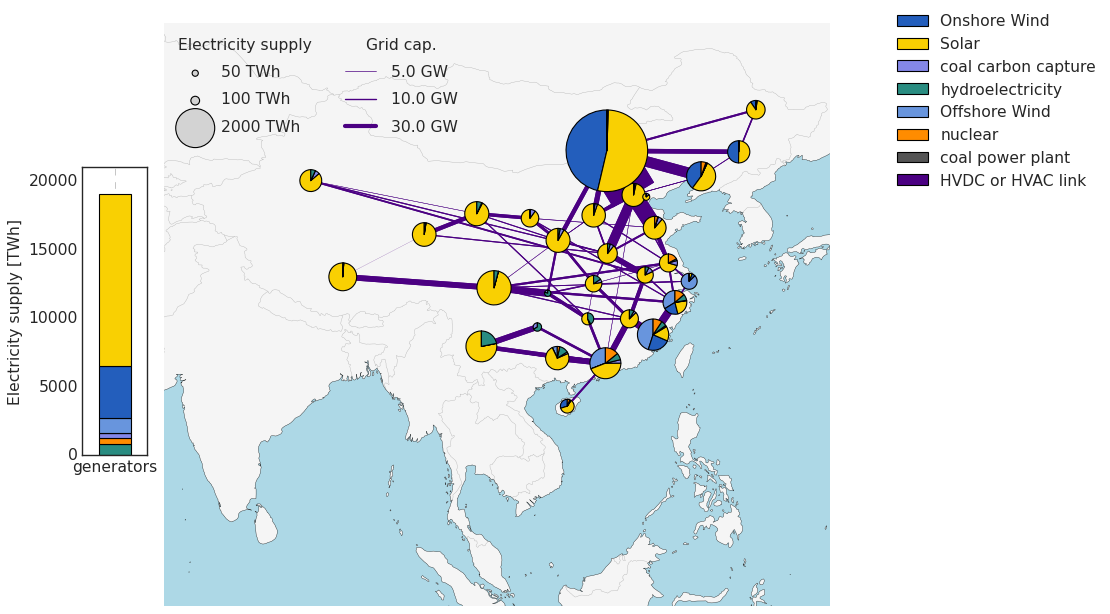

In [23]:
from plot_network import plot_energy_map
from _plot_utilities import set_plot_style
set_plot_style(
    style_config_file= r"/home/ivanra/documents/PyPSA-China-PIK/config/plotting_styles/network_map.mplstyle",
    #snakemake.config["plotting"]["network_style_config_file"],
    base_styles=["classic", "seaborn-v0_8-white"],
)
plot_energy_map(n,config["plotting"], carrier="AC")

In [24]:
supply_pies = n.statistics.supply(
        groupby=pypsa.statistics.get_bus_and_carrier, bus_carrier=None, comps=["Link"]
    ).droplevel(0)
supply_pies.index.get_level_values(1).unique()

Index(['AC', 'CHP coal', 'CHP gas', 'H2 CHP', 'OCGT gas', 'battery discharger',
       'biomass', 'CO2 capture', 'Hydrogen Storage', 'Battery Storage',
       'Heat Pump', 'coal boiler', 'resistive heater', 'water tanks',
       'gas boiler', 'Sabatier', 'hydroelectricity', 'stations'],
      dtype='object', name='carrier')

In [25]:
n.statistics.supply(bus_carrier="H2", nice_names=False)

component  carrier
Link       H2         2.246046e+09
Store      H2         6.787642e+08
dtype: float64

In [26]:
lnks_p1= n.dynamic("Link").p1.sum()
lnks_p1

Link
Ahai station-Jinanqiao station spillage       -4.256843e+05
Ahai turbines                                 -6.551409e+06
Anhui H2 Electrolysis-2060                    -9.429967e+02
Anhui OCGT-2055                               -6.041142e+06
Anhui OCGT-2060                               -8.747388e+06
                                                   ...     
Zhejiang-Shanghai H2 pipeline reversed-2050   -6.258028e+02
Zhejiang-Shanghai H2 pipeline reversed-2060   -2.155154e+03
Zhejiang-Shanghai ext reversed                -1.885364e+07
Zhejiang-Shanghai reversed                    -5.443684e+03
Zhejiang-Sichuan ext reversed                 -1.458004e+07
Length: 2298, dtype: float64

In [27]:
n.dynamic("Link").p0.sum()

Link
Anhui central biomass CHP capture-2060        3.765279e+05
Beijing central biomass CHP capture-2060      3.760495e+04
Chongqing central biomass CHP capture-2060    9.899004e+02
Fujian central biomass CHP capture-2060       1.784270e+05
Gansu central biomass CHP capture-2060        5.824841e+05
                                                  ...     
Sichuan-Shaanxi ext reversed                  6.792616e+06
Sichuan-Shanghai ext reversed                 2.224359e+07
Zhejiang-Shanghai ext reversed                1.938497e+07
Tibet-Sichuan ext reversed                    4.173955e+05
Zhejiang-Sichuan ext reversed                 1.562313e+07
Length: 2298, dtype: float64

In [28]:
n.links_t.p0

Link                 Anhui central biomass CHP capture-2060  \
snapshot                                                      
2059-12-31 16:00:00                               59.518372   
2059-12-31 17:00:00                               59.518886   
2059-12-31 18:00:00                               59.518402   
2059-12-31 19:00:00                               59.518394   
2059-12-31 20:00:00                               59.518398   
...                                                     ...   
2060-12-31 11:00:00                               59.518928   
2060-12-31 12:00:00                               59.518918   
2060-12-31 13:00:00                               59.518899   
2060-12-31 14:00:00                               59.518880   
2060-12-31 15:00:00                               59.518868   

Link                 Beijing central biomass CHP capture-2060  \
snapshot                                                        
2059-12-31 16:00:00                                 10.711483   
2059-12-31 17:00:00                                 10.711403   
2059-12-31 18:00:00                                 10.711374   
2059-12-31 19:00:00                                 10.711356   
2059-12-31 20:00:00                                 10.711346   
...                                                       ...   
2060-12-31 11:00:00                                 10.711223   
2060-12-31 12:00:00                                 10.711221   
2060-12-31 13:00:00                                 10.711220   
2060-12-31 14:00:00                                 10.711245   
2060-12-31 15:00:00                                 10.711241   

Link                 Chongqing central biomass CHP capture-2060  \
snapshot                                                          
2059-12-31 16:00:00                                    0.153882   
2059-12-31 17:00:00                                    0.154291   
2059-12-31 18:00:00                                    0.154221   
2059-12-31 19:00:00                                    0.154223   
2059-12-31 20:00:00                                    0.154284   
...                                                         ...   
2060-12-31 11:00:00                                    0.154514   
2060-12-31 12:00:00                                    0.154569   
2060-12-31 13:00:00                                    0.154586   
2060-12-31 14:00:00                                    0.154576   
2060-12-31 15:00:00                                    0.154567   

Link                 Fujian central biomass CHP capture-2060  \
snapshot                                                       
2059-12-31 16:00:00                                27.727823   
2059-12-31 17:00:00                                27.727876   
2059-12-31 18:00:00                                27.727973   
2059-12-31 19:00:00                                27.728042   
2059-12-31 20:00:00                                27.728088   
...                                                      ...   
2060-12-31 11:00:00                                27.728498   
2060-12-31 12:00:00                                27.728489   
2060-12-31 13:00:00                                27.728114   
2060-12-31 14:00:00                                27.728134   
2060-12-31 15:00:00                                27.728127   

Link                 Gansu central biomass CHP capture-2060  \
snapshot                                                      
2059-12-31 16:00:00                              134.160651   
2059-12-31 17:00:00                              134.160916   
2059-12-31 18:00:00                              134.160890   
2059-12-31 19:00:00                              134.160879   
2059-12-31 20:00:00                              134.160884   
...                                                     ...   
2060-12-31 11:00:00                              134.161140   
2060-12-31 12:00:00                              134.161137   

In [29]:
lks = n.links
lkh2 = lks[lks.carrier=="H2"]

In [30]:
lkh2["type"] = lkh2.apply(lambda x: x.name.split(x.bus1)[1].strip().split("-")[0], axis=1)
lkh2.type.unique()

/tmp/ipykernel_12268/4231844236.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



array(['Electrolysis', 'pipeline positive', 'pipeline reversed'],
      dtype=object)

In [31]:
lkh2.columns

Index(['bus0', 'bus1', 'type', 'carrier', 'efficiency', 'active', 'build_year',
       'lifetime', 'p_nom', 'p_nom_mod', 'p_nom_extendable', 'p_nom_min',
       'p_nom_max', 'p_set', 'p_min_pu', 'p_max_pu', 'capital_cost',
       'marginal_cost', 'marginal_cost_quadratic', 'stand_by_cost', 'length',
       'terrain_factor', 'committable', 'start_up_cost', 'shut_down_cost',
       'min_up_time', 'min_down_time', 'up_time_before', 'down_time_before',
       'ramp_limit_up', 'ramp_limit_down', 'ramp_limit_start_up',
       'ramp_limit_shut_down', 'p_nom_opt', 'bus3', 'efficiency3', 'bus2',
       'efficiency2', 'c_b'],
      dtype='object')

In [32]:
# Split the index and create a new column for the year
lkh2['year'] = lkh2.index.str.split('-').str[-1].astype(int)
lkh2['bus1'] = lkh2.index.str.split('-').str[0]
lkh2.reset_index(drop=True, inplace=True)

/tmp/ipykernel_12268/2625175559.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_12268/2625175559.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/home/ivanra/miniconda3/envs/pypsa-china/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



<GeoAxes: >

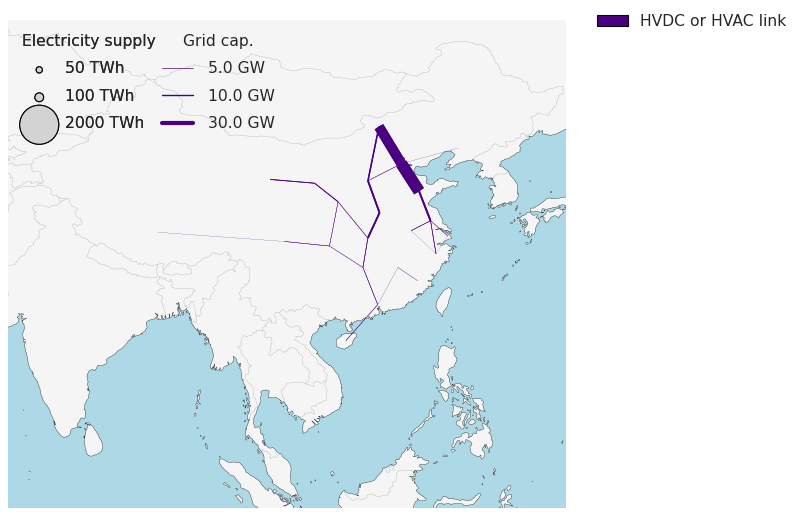

In [33]:
plot_ntwk = n.copy()
carrier = "H2"
# avoid cluttering the plot
plot_ntwk.buses.drop(plot_ntwk.buses.index[plot_ntwk.buses.carrier != carrier], inplace=True)
plot_ntwk.links.drop(
    plot_ntwk.links.index[plot_ntwk.links.length == 0],
    inplace=True,
)

supply_pies = plot_ntwk.statistics.supply(
        groupby=pypsa.statistics.get_bus_and_carrier, bus_carrier=carrier, comps=["Generator"]
    ).droplevel(0)

# get all carrier types
carriers_list = supply_pies.index.get_level_values(1).unique()
carriers_list = carriers_list.tolist()

# TODO make line handling nicer
line_lower_threshold = 500.0
line_upper_threshold = 1e4
# Make figure
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(opts["energy_map"]["figsize"])
# get colors
bus_colors = plot_ntwk.carriers.loc[plot_ntwk.carriers.nice_name.isin(carriers_list), "color"]
bus_colors.rename(opts["nice_names"], inplace=True)
# Add the total costs
bus_size_factor = opts["energy_map"]["bus_size_factor"]/1e2
linewidth_factor = opts["energy_map"]["linewidth_factor"]*1
edges = pd.concat([plot_ntwk.lines.s_nom_opt, plot_ntwk.links.p_nom_opt])
edge_widths = (
    edges
    .clip(line_lower_threshold, edges.max())
    .replace(line_lower_threshold, 0)
)
preferred_order = pd.Index(opts["preferred_order"])
reordered = preferred_order.intersection(bus_colors.index).append(
    bus_colors.index.difference(preferred_order)
)

plot_map(
    plot_ntwk,
    tech_colors=plot_ntwk.carriers.color,
    edge_widths=edge_widths / linewidth_factor,
    bus_colors=bus_colors.loc[reordered],
    bus_sizes=supply_pies / 1,
    edge_colors="indigo",
    ax=ax,
    edge_unit_conv=PLOT_CAP_UNITS,
    bus_unit_conv=PLOT_SUPPLY_UNITS,
    add_legend=True,
    **opts["energy_map"],
)

Plot availability

## plot capacity

## plot cost

## Interactive plot map

In [34]:

import numpy as np
# make names and link sizes, make sure we only plot AC, DC & statiosn
ac_links = n.links[n.links.carrier == "AC"]
colors = n.links.index.to_series().apply(lambda x: 'black' if 'ext' in x else 'pink')
widths = np.log(n.links.p_nom_opt + 3) / 2
widths[~widths.index.isin(ac_links.index)] = 0
widths[widths.index.str.contains('reversed')] = 0
names = n.links.copy()
names["name"] = names.index.values
names.loc[~names.index.isin(ac_links.index), "p_nom_opt"] = ""
names.loc[~names.index.isin(ac_links.index), "name"] = ""
buses = n.buses.copy()
buses["name"] = buses.apply(lambda x: f"{x.name}" if x.carrier == "AC" or x.carrier=="stations" else "", axis=1)
buses["sizes"] = buses.apply(lambda x:10 if x.carrier == "AC" or x.carrier=="stations" else 0, axis=1)
buses["colors"] = buses.apply(lambda x: "black" if x.carrier == "AC" else "red", axis=1)
buses.carrier.unique()
ax = n.iplot(link_colors=colors, link_widths=widths, link_text = names.p_nom_opt.astype(str) + names.name, bus_text=buses.name, bus_sizes=buses.sizes, bus_colors=buses.colors)

/tmp/ipykernel_12268/1096144582.py:10: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



In [35]:
n.links[(n.links.length != 0)&(n.links.index.str.find("reversed")<0)].p_nom_opt.sort_values(ascending=False).round(2).head(20)

Link
Hebei-InnerMongolia positive                     345364.58
Hebei-Shandong positive                          117889.82
Hebei-Shandong H2 pipeline positive-2060          83553.32
Liaoning-InnerMongolia positive                   76540.85
Hebei-InnerMongolia H2 pipeline positive-2060     71918.15
Hebei-Henan positive                              69108.39
Fujian-Zhejiang positive                          55550.56
Fujian-Jiangxi positive                           50565.33
Chongqing-Sichuan positive                        50504.80
Guangdong-Jiangxi positive                        42226.86
Guangdong-Guangxi ext positive                    41690.00
Hebei-InnerMongolia H2 pipeline positive-2055     41435.18
Sichuan-Tibet positive                            41277.92
Hebei-Shandong H2 pipeline positive-2055          40865.95
Guizhou-Yunnan positive                           40396.40
Anhui-Henan positive                              39430.10
InnerMongolia-Shanxi positive                     3

### extendable lines

/home/ivanra/miniconda3/envs/pypsa-china/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



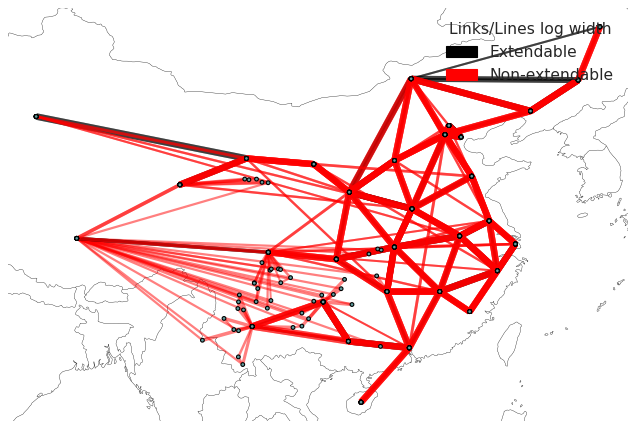

In [36]:

fig, ax = plt.subplots(1, 1, figsize=(10, 10),subplot_kw={"projection":ccrs.PlateCarree()})
def width(x):
    return np.log10(x/1e6).where(x>1,0)
n.plot(ax = ax,link_colors=n.links.p_nom_extendable.apply(lambda x: "red" if not x else "black"),line_colors=n.lines.s_nom_extendable.apply(lambda x: "red" if not x else "black"), link_widths= width(n.links.p_nom_opt) , line_widths=width(n.lines.s_nom_opt), link_alpha=0.5)
# Create custom legend
import matplotlib.patches as mpatches
extendable_patch = mpatches.Patch(color='black', label='Extendable')
non_extendable_patch = mpatches.Patch(color='red', label='Non-extendable')
ax.legend(handles=[extendable_patch, non_extendable_patch], title = "Links/Lines log width")

# Shadow prices & prices


In [39]:
n.global_constraints

type  investment_period carrier_attribute sense  \
GlobalConstraint                                                              
co2_limit         primary_energy                NaN     co2_emissions    <=   

                  constant     mu  
GlobalConstraint                   
co2_limit              0.0 -164.0

# CO2 emissions

In [40]:
CO2_CONV = 1e6 # t->Mt
def calc_co2(n:pypsa.Network, withdrawal_stores = ["CO2 capture"])->tuple[float,float,float]:
    """calc the co2 balance
    [DOES NOT INCLUDE GENERATING]
    Args:
        n (pypsa.Network): the network object
        withdrawal_stores (list, optional): names of stores. Defaults to ["CO2 capture"].

    Returns:
        tuple[float,float,float]: balance, gen, withdrawal
    """
    # emissions from generators (from fneumann course)
    emissions = (
    n.generators_t.p
    / n.generators.efficiency
    * n.generators.carrier.map(n.carriers.co2_emissions)
    )  # t/h
    gen_emissions = n.snapshot_weightings.generators @ emissions.sum(axis=1).div(CO2_CONV)  # Mt

    # withdrawal
    stores = n.stores_t.e.T.groupby(n.stores.carrier).sum()
    
    co2_cap = stores.iloc[:, -1].loc[withdrawal_stores].sum()/CO2_CONV # Mt

    return gen_emissions-co2_cap, gen_emissions, co2_cap



In [41]:
calc_co2(n)

(6.49314984002558e-08, 307.2523651896423, 307.2523651247108)

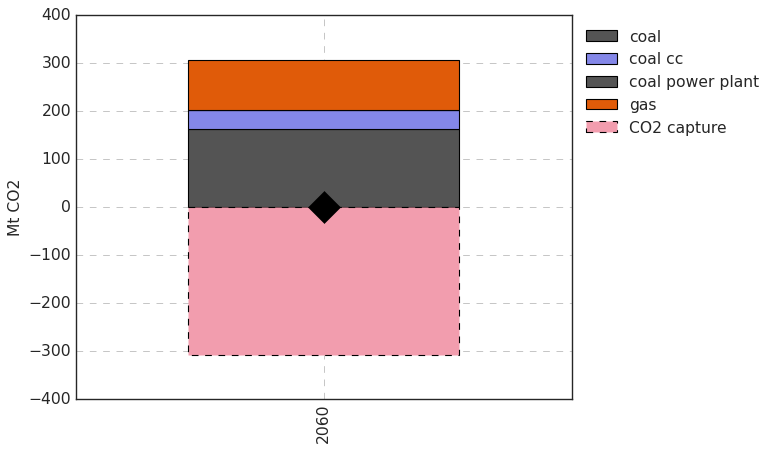

In [42]:
def plot_co2_balance(n:pypsa.Network, withdrawal_stores = ["CO2 capture"], ax = None)->tuple[float,float,float]:
    """calc the co2 balance
    [DOES NOT INCLUDE GENERATING LINKSs]
    Args:
        n (pypsa.Network): the network object
        withdrawal_stores (list, optional): names of stores. Defaults to ["CO2 capture"].

    Returns:
        tuple[float,float,float]: balance, gen, withdrawal
    """

    # year *(assumes one planning year intended),
    year = int(np.round(n.snapshots.year.values.mean(),0))

    # emissions from generators (from fneumann course)
    emissions = (
    n.generators_t.p
    / n.generators.efficiency
    * n.generators.carrier.map(n.carriers.co2_emissions)
    )  # t/h
    emissions_carrier =(n.snapshot_weightings.generators @ emissions).groupby(n.generators.carrier).sum()
    
    # format and drop 0 values
    emissions_carrier = emissions_carrier.where(emissions_carrier > 0).dropna()
    emissions_carrier.rename(year, inplace=True)
    emissions_carrier = emissions_carrier.div(CO2_CONV).to_frame()
    # CO2 withdrawal
    stores = n.stores_t.e.T.groupby(n.stores.carrier).sum()
    co2_cap = stores.iloc[:, -1].loc[withdrawal_stores]*-1/CO2_CONV # Mt
    co2_cap.rename(year, inplace=True)
    co2_cap = co2_cap.to_frame()

    # plot
    if ax is None:
        fig, ax = plt.subplots()

    emissions_carrier.T.plot( kind="bar", stacked=True, width = 0.6, ax =ax, color = emissions_carrier.index.map(n.carriers.color))
    co2_cap.T.plot(kind="bar", ax = ax, width = 0.6, linestyle="--", color = co2_cap.index.map(n.carriers.color))
    
    # Add a diamond at the total emissions
    emissions_tot = co2_cap.sum()+emissions_carrier.sum().sum()
    handles, labels = ax.get_legend_handles_labels()
    ax.set_ylabel("Mt CO2")
    ax.legend(handles, labels, ncol=1, bbox_to_anchor=[1, 1], loc="upper left")
    ax.plot(np.average(ax.get_xlim()), emissions_tot, marker="D", markersize=20, color="black")
    
    return ax, co2_cap, emissions_carrier

ax, gen, co2_cap=plot_co2_balance(n)


In [43]:
def calc_co2_balance(n:pypsa.Network, withdrawal_stores = ["CO2 capture"], ax = None)->tuple[float,float,float]:
    """calc the co2 balance
    [DOES NOT INCLUDE GENERATING LINKSs]
    Args:
        n (pypsa.Network): the network object
        withdrawal_stores (list, optional): names of stores. Defaults to ["CO2 capture"].

    Returns:
        tuple[float,float,float]: balance, gen, withdrawal
    """

    # year *(assumes one planning year intended),
    year = int(np.round(n.snapshots.year.values.mean(),0))

    # emissions from generators (from fneumann course)
    emissions = (
    n.generators_t.p
    / n.generators.efficiency
    * n.generators.carrier.map(n.carriers.co2_emissions)
    )  # t/h
    emissions_carrier =(n.snapshot_weightings.generators @ emissions).groupby(n.generators.carrier).sum()
    
    # format and drop 0 values
    emissions_carrier = emissions_carrier.where(emissions_carrier > 0).dropna()
    emissions_carrier.rename(year, inplace=True)
    emissions_carrier = emissions_carrier.div(CO2_CONV).to_frame()
    # CO2 withdrawal
    stores = n.stores_t.e.T.groupby(n.stores.carrier).sum()
    co2_withdrawal = stores.iloc[:, -1].loc[withdrawal_stores]*-1/CO2_CONV # Mt
    co2_withdrawal.rename(year, inplace=True)
    co2_withdrawal = co2_withdrawal.to_frame()

    return pd.concat([emissions_carrier, co2_withdrawal])

co2_balance = calc_co2_balance(n)
co2_balance.to_csv("co2_balance.csv")

<Axes: xlabel='snapshot'>

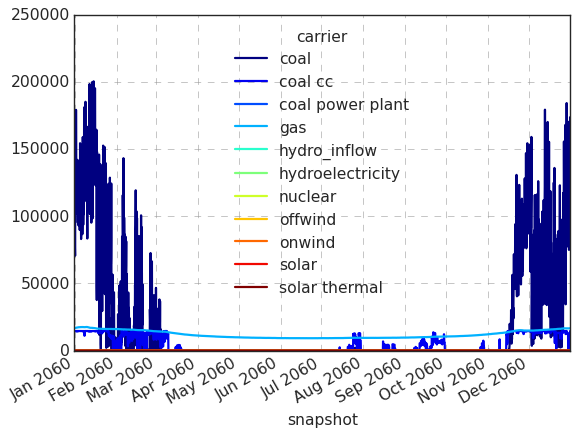

In [44]:
fig, ax = plt.subplots()
# calc the t resolved CO2 emissions from generators
((n.generators_t.p/ n.generators.efficiency)* n.generators.carrier.map(n.carriers.co2_emissions)).T.groupby(n.generators.carrier).sum().T.plot(ax =ax, cmap = "jet")

Text(0, 0.5, 'cum CO2 emissions [t]')

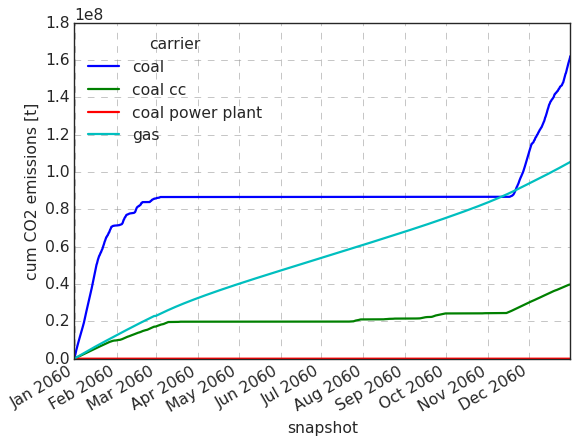

In [45]:
gen_emissions = ((n.generators_t.p/ n.generators.efficiency)* n.generators.carrier.map(n.carriers.co2_emissions)).T.groupby(n.generators.carrier).sum().T.cumsum()
fig, ax = plt.subplots()
gen_emissions.where(gen_emissions>0).dropna(axis=1, how="all").plot(ax=ax)
ax.set_ylabel("cum CO2 emissions [t]")


(1000.0, 10000000000.0)

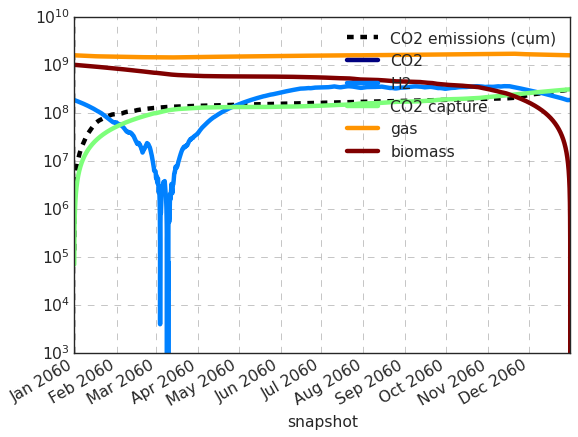

In [46]:
fig, ax = plt.subplots()
# calc the t resolved CO2 emissions from generators
((n.generators_t.p/ n.generators.efficiency)* n.generators.carrier.map(n.carriers.co2_emissions)).T.groupby(n.generators.carrier).sum().sum().T.cumsum().plot(ax =ax, label = "CO2 emissions (cum)", lw=4, c ="black", ls = "--")
n.stores_t.e.T.groupby(n.stores.carrier).sum().loc[["CO2","H2", "CO2 capture", "gas", "biomass"]].T.plot(lw=4, cmap ="jet", ax =ax)
ax.legend()
ax.semilogy()
ax.set_ylim(1e3,1e10)

## CO2 capture
! beware the store is the difference :)

In [47]:
stores = n.stores_t.e.T.groupby(n.stores.carrier).sum()
diff = stores.iloc[:, -1] -stores.iloc[:, 0]
co2_cap = stores.iloc[:, -1].loc[["CO2 capture"]].sum()
co2_cap


307252365.1247108

<Axes: xlabel='snapshot'>

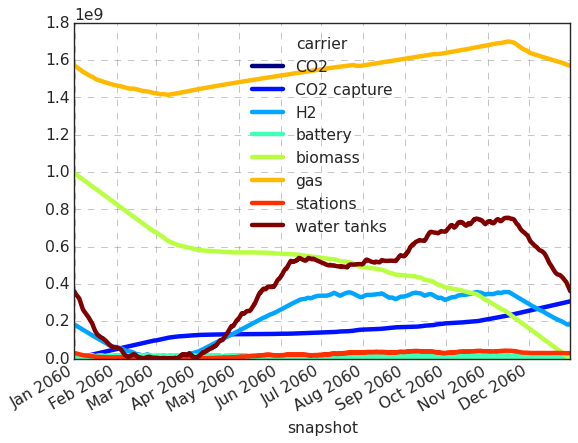

In [48]:
n.stores_t.e.T.groupby(n.stores.carrier).sum().T.plot(lw=4, cmap ="jet")

In [49]:
n.stores[n.stores.carrier == "CO2 capture"].e_nom_opt.sum()/1e6

62231.772827755965

In [50]:
n.

SyntaxError: invalid syntax (395983660.py, line 1)

In [ ]:
n.links[n.links.carrier == "CO2 capture"]

bus0  \
Link                                                        
Anhui central biomass CHP capture-2060          Anhui CO2   
Beijing central biomass CHP capture-2060      Beijing CO2   
Chongqing central biomass CHP capture-2060  Chongqing CO2   
Fujian central biomass CHP capture-2060        Fujian CO2   
Gansu central biomass CHP capture-2060          Gansu CO2   
...                                                   ...   
Tianjin central biomass CHP capture-2035      Tianjin CO2   
Tibet central biomass CHP capture-2035          Tibet CO2   
Xinjiang central biomass CHP capture-2035    Xinjiang CO2   
Yunnan central biomass CHP capture-2035        Yunnan CO2   
Zhejiang central biomass CHP capture-2035    Zhejiang CO2   

                                                             bus1 type  \
Link                                                                     
Anhui central biomass CHP capture-2060          Anhui CO2 capture        
Beijing central biomass CHP capture-2060      Beijing CO2 capture        
Chongqing central biomass CHP capture-2060  Chongqing CO2 capture        
Fujian central biomass CHP capture-2060        Fujian CO2 capture        
Gansu central biomass CHP capture-2060          Gansu CO2 capture        
...                                                           ...  ...   
Tianjin central biomass CHP capture-2035      Tianjin CO2 capture        
Tibet central biomass CHP capture-2035          Tibet CO2 capture        
Xinjiang central biomass CHP capture-2035    Xinjiang CO2 capture        
Yunnan central biomass CHP capture-2035        Yunnan CO2 capture        
Zhejiang central biomass CHP capture-2035    Zhejiang CO2 capture        

                                                carrier  efficiency  active  \
Link                                                                          
Anhui central biomass CHP capture-2060      CO2 capture        0.95    True   
Beijing central biomass CHP capture-2060    CO2 capture        0.95    True   
Chongqing central biomass CHP capture-2060  CO2 capture        0.95    True   
Fujian central biomass CHP capture-2060     CO2 capture        0.95    True   
Gansu central biomass CHP capture-2060      CO2 capture        0.95    True   
...                                                 ...         ...     ...   
Tianjin central biomass CHP capture-2035    CO2 capture        0.92    True   
Tibet central biomass CHP capture-2035      CO2 capture        0.92    True   
Xinjiang central biomass CHP capture-2035   CO2 capture        0.92    True   
Yunnan central biomass CHP capture-2035     CO2 capture        0.92    True   
Zhejiang central biomass CHP capture-2035   CO2 capture        0.92    True   

                                            build_year  lifetime     p_nom  \
Link                                                                         
Anhui central biomass CHP capture-2060            2060      25.0  0.000000   
Beijing central biomass CHP capture-2060          2060      25.0  0.000000   
Chongqing central biomass CHP capture-2060        2060      25.0  0.000000   
Fujian central biomass CHP capture-2060           2060      25.0  0.000000   
Gansu central biomass CHP capture-2060            2060      25.0  0.000000   
...                                                ...       ...       ...   
Tianjin central biomass CHP capture-2035          2035      25.0  0.005307   
Tibet central biomass CHP capture-2035            2035      25.0  0.002687   
Xinjiang central biomass CHP capture-2035         2035      25.0  0.005192   
Yunnan central biomass CHP capture-2035           2035      25.0  0.006517   
Zhejiang central biomass CHP capture-2035         2035      25.0  0.005113   

                                            p_nom_mod  ...  ramp_limit_up  \
Link                                                   ...                  
Anhui central biomass CHP capture-2060            0.0  ...            NaN   
Beijing central biomas

In [ ]:
[[c for c in n.links_t["efficiency"].columns if c.lower().find("capture")>=0 or c.lower().find("cc")>=0]]n.links_t["efficiency"]

Empty DataFrame
Columns: []
Index: [2059-12-31 16:00:00, 2059-12-31 17:00:00, 2059-12-31 18:00:00, 2059-12-31 19:00:00, 2059-12-31 20:00:00, 2059-12-31 21:00:00, 2059-12-31 22:00:00, 2059-12-31 23:00:00, 2060-01-01 00:00:00, 2060-01-01 01:00:00, 2060-01-01 02:00:00, 2060-01-01 03:00:00, 2060-01-01 04:00:00, 2060-01-01 05:00:00, 2060-01-01 06:00:00, 2060-01-01 07:00:00, 2060-01-01 08:00:00, 2060-01-01 09:00:00, 2060-01-01 10:00:00, 2060-01-01 11:00:00, 2060-01-01 12:00:00, 2060-01-01 13:00:00, 2060-01-01 14:00:00, 2060-01-01 15:00:00, 2060-01-01 16:00:00, 2060-01-01 17:00:00, 2060-01-01 18:00:00, 2060-01-01 19:00:00, 2060-01-01 20:00:00, 2060-01-01 21:00:00, 2060-01-01 22:00:00, 2060-01-01 23:00:00, 2060-01-02 00:00:00, 2060-01-02 01:00:00, 2060-01-02 02:00:00, 2060-01-02 03:00:00, 2060-01-02 04:00:00, 2060-01-02 05:00:00, 2060-01-02 06:00:00, 2060-01-02 07:00:00, 2060-01-02 08:00:00, 2060-01-02 09:00:00, 2060-01-02 10:00:00, 2060-01-02 11:00:00, 2060-01-02 12:00:00, 2060-01-02 13:00:00, 2060-01-02 14:00:00, 2060-01-02 15:00:00, 2060-01-02 16:00:00, 2060-01-02 17:00:00, 2060-01-02 18:00:00, 2060-01-02 19:00:00, 2060-01-02 20:00:00, 2060-01-02 21:00:00, 2060-01-02 22:00:00, 2060-01-02 23:00:00, 2060-01-03 00:00:00, 2060-01-03 01:00:00, 2060-01-03 02:00:00, 2060-01-03 03:00:00, 2060-01-03 04:00:00, 2060-01-03 05:00:00, 2060-01-03 06:00:00, 2060-01-03 07:00:00, 2060-01-03 08:00:00, 2060-01-03 09:00:00, 2060-01-03 10:00:00, 2060-01-03 11:00:00, 2060-01-03 12:00:00, 2060-01-03 13:00:00, 2060-01-03 14:00:00, 2060-01-03 15:00:00, 2060-01-03 16:00:00, 2060-01-03 17:00:00, 2060-01-03 18:00:00, 2060-01-03 19:00:00, 2060-01-03 20:00:00, 2060-01-03 21:00:00, 2060-01-03 22:00:00, 2060-01-03 23:00:00, 2060-01-04 00:00:00, 2060-01-04 01:00:00, 2060-01-04 02:00:00, 2060-01-04 03:00:00, 2060-01-04 04:00:00, 2060-01-04 05:00:00, 2060-01-04 06:00:00, 2060-01-04 07:00:00, 2060-01-04 08:00:00, 2060-01-04 09:00:00, 2060-01-04 10:00:00, 2060-01-04 11:00:00, 2060-01-04 12:00:00, 2060-01-04 13:00:00, 2060-01-04 14:00:00, 2060-01-04 15:00:00, 2060-01-04 16:00:00, 2060-01-04 17:00:00, 2060-01-04 18:00:00, 2060-01-04 19:00:00, ...]

[8760 rows x 0 columns]

# plot time series

In [ ]:
from plot_time_series import plot_energy_balance

/home/ivanra/miniconda3/envs/pypsa-china/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1798: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



Text(0.5, 1.0, 'Electricity Balance')

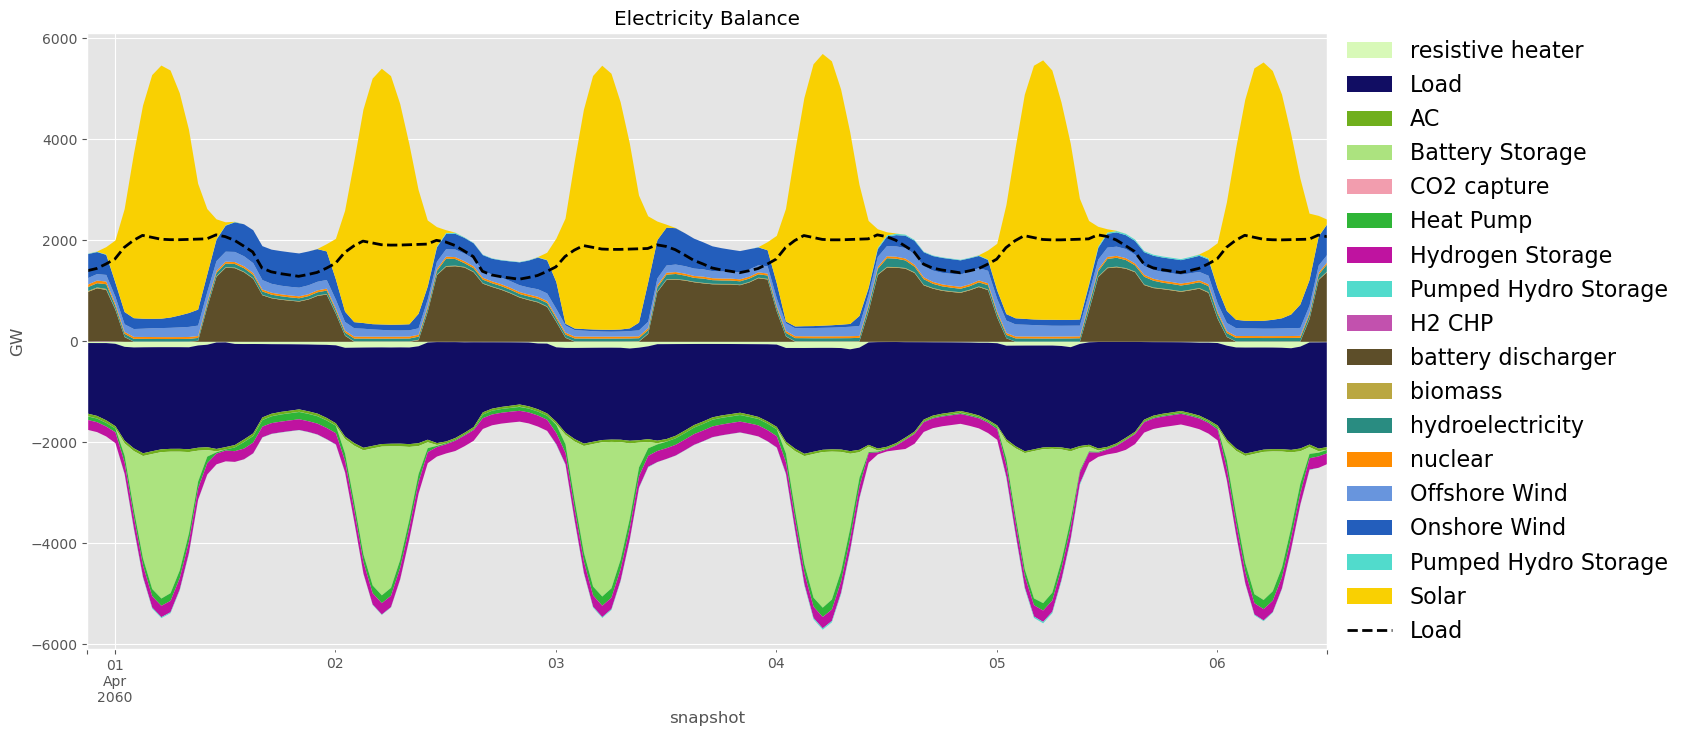

In [ ]:
ax = plot_energy_balance(n, config["plotting"], start_date="2060-03-31 21:00", end_date="2060-04-06 12:00:00")
ax.grid(axis='y')
ax.set_title("Electricity Balance")

/home/ivanra/miniconda3/envs/pypsa-china/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1798: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



Text(0.5, 1.0, 'Heat balance')

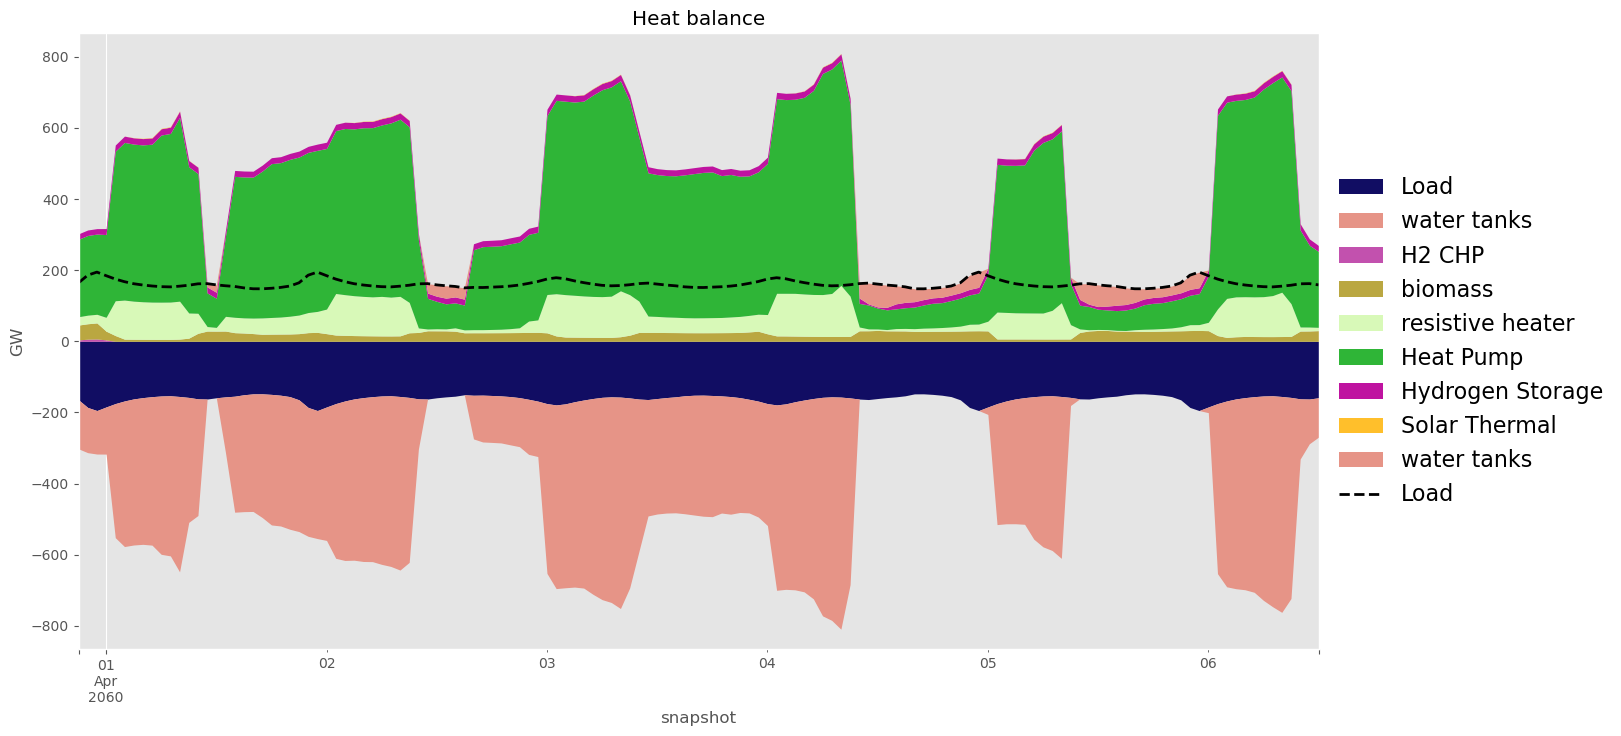

In [ ]:
ax = plot_energy_balance(n, config["plotting"], start_date="2060-03-31 21:00", end_date="2060-04-06 12:00:00", bus_carrier="heat")
ax.set_title("Heat balance")

Text(0, 0.5, 'EnergyDemand / GW')

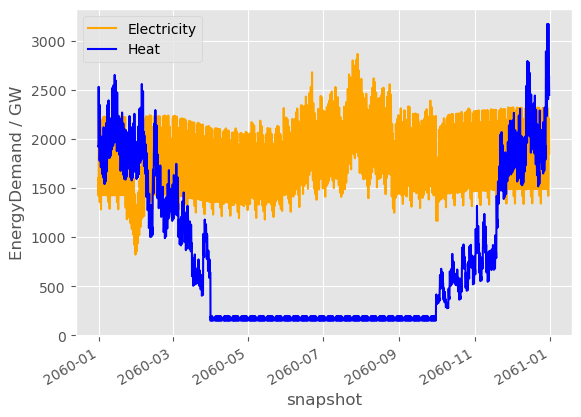

In [ ]:
fix, ax = plt.subplots()
ds_AC = n.statistics.withdrawal(bus_carrier="AC", aggregate_time=False).loc[("Load", "-")]/1e3
ds_heat = n.statistics.withdrawal(bus_carrier="heat", aggregate_time=False).loc[("Load", "-")]/1e3
ds_AC.plot(ax=ax, label="Electricity",  c="orange")
ds_heat.plot(ax=ax, label="Heat", c = "blue")
ax.legend()
ax.set_ylabel("EnergyDemand / GW")

In [ ]:
capacity_factors = n.statistics.capacity_factor(aggregate_time=False).loc[["Generator"]].droplevel(0).T

In [56]:
n.generators[n.generators.carrier.isin(['onwind',
       'offwind'])].p_max_pu

Generator
Anhui onwind-2060            1.0
Beijing onwind-2060          1.0
Chongqing onwind-2060        1.0
Fujian onwind-2060           1.0
Gansu onwind-2060            1.0
                            ... 
Hainan onwind-2030           1.0
InnerMongolia onwind-2030    1.0
Jilin onwind-2030            1.0
Liaoning onwind-2030         1.0
Fujian offwind-2030          1.0
Name: p_max_pu, Length: 90, dtype: float64

In [57]:
cap_fac = n.generators_t.p_max_pu
cap_fac_w = cap_fac[[c for c in cap_fac.columns if c.find("wind")>=0]]
cap_fac_offw = cap_fac[[c for c in cap_fac.columns if c.find("offwind")>=0]]

cap_fac_onw = cap_fac[[c for c in cap_fac.columns if c.find("onwind")>=0]]

In [60]:
n.generators.groupby(n.generators.carrier).sum()

bus  \
carrier                                                               
coal              Anhui coalBeijing coalChongqing coalFujian coa...   
coal cc           AnhuiBeijingChongqingFujianGansuGuangdongGuang...   
coal power plant                                           Xinjiang   
gas               Anhui gasBeijing gasChongqing gasFujian gasGan...   
hydro_inflow      Sanxia stationXiluodu stationNuozhadu stationJ...   
hydroelectricity  AnhuiBeijingChongqingFujianGansuGuangdongGuang...   
nuclear           LiaoningShandongJiangsuZhejiangFujianGuangdong...   
offwind           FujianGuangdongGuangxiHainanHebeiJiangsuLiaoni...   
onwind            AnhuiBeijingChongqingFujianGansuGuangdongGuang...   
solar             AnhuiBeijingChongqingFujianGansuGuangdongGuang...   
solar thermal     Anhui decentral heatBeijing decentral heatChon...   

                                                            control type  \
carrier                                                                    
coal              PQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQ...        
coal cc           PQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQ...        
coal power plant                                                 PQ        
gas               PQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQ...        
hydro_inflow         PQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQ        
hydroelectricity  PQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQ...        
nuclear                            PQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQ        
offwind           PQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQ...        
onwind            PQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQ...        
solar             PQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQ...        
solar thermal     PQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQ...        

                         p_nom  p_nom_mod  p_nom_extendable  p_nom_min  \
carrier                                                                  
coal              3.100000e+09        0.0                 0        0.0   
coal cc           1.421236e+05        0.0                31        0.0   
coal power plant  4.228163e+03        0.0                 1        0.0   
gas               3.100000e+09        0.0                 0        0.0   
hydro_inflow      6.370307e+06        0.0                 0        0.0   
hydroelectricity  2.253780e+05        0.0                 0        0.0   
nuclear           5.464700e+04        0.0                 8    54647.0   
offwind           3.098862e+05        0.0                11        0.0   
onwind            1.088312e+06        0.0                31        0.0   
solar             8.491308e+06        0.0                31        0.0   
solar thermal     2.046697e+03        0.0                62        0.0   

                  p_nom_max  p_min_pu  p_max_pu  ...  min_up_time  \
carrier                                          ...                
coal                    inf       0.0      31.0  ...            0   
coal cc                 inf       0.0      90.0  ...            0   
coal power plant        inf       0.0       1.0  ...            0   
gas                     inf       0.0      31.0  ...            0   
hydro_inflow            inf       0.0      23.0  ...            0   
hydroelectricity        inf       0.0      31.0  ...            0   
nuclear                 inf      11.2      16.0  ...            0   
offwind                 inf       0.0      26.0  ...            0   
onwind                  inf       0.0      64.0  ...            0   
solar                   inf       0.0     187.0  ...            0   
solar thermal           inf       0.0      66.0  ...            0   

                  min_down_time  up_time_before  down_time_before  \
carrier                                                             
coal                          0              31                 0   
coal cc                       0              90                 0   
coal power pla

In [59]:
cap_fac.T.groupby(n.generators.carrier).sum()

snapshot          2059-12-31 16:00:00  2059-12-31 17:00:00  \
carrier                                                      
hydro_inflow                 0.436434             0.000000   
hydroelectricity             3.358987             3.213269   
offwind                     12.749235            12.334300   
onwind                      16.044428            15.032931   
solar                        0.000000             0.000000   
solar thermal                0.000000             0.000000   

snapshot          2059-12-31 18:00:00  2059-12-31 19:00:00  \
carrier                                                      
hydro_inflow                 0.000000             0.000000   
hydroelectricity             3.146133             3.090891   
offwind                     12.012917            11.830293   
onwind                      13.976141            13.241973   
solar                        0.000000             0.000000   
solar thermal                0.000000             0.000000   

snapshot          2059-12-31 20:00:00  2059-12-31 21:00:00  \
carrier                                                      
hydro_inflow                 0.000000             0.000000   
hydroelectricity             3.062438             3.145978   
offwind                     11.590875            11.297902   
onwind                      12.662726            12.207281   
solar                        0.000000             0.000000   
solar thermal                0.000000             0.000000   

snapshot          2059-12-31 22:00:00  2059-12-31 23:00:00  \
carrier                                                      
hydro_inflow                 0.000000             0.000000   
hydroelectricity             3.670534             4.532848   
offwind                      9.970846            10.013885   
onwind                      10.520988            10.518443   
solar                        0.000000             0.000000   
solar thermal                0.000000             0.000000   

snapshot          2060-01-01 00:00:00  2060-01-01 01:00:00  ...  \
carrier                                                     ...   
hydro_inflow                 0.000000             0.000000  ...   
hydroelectricity             4.324016             3.706055  ...   
offwind                     10.172609            10.228330  ...   
onwind                      10.372550            10.862576  ...   
solar                        4.485025            25.963237  ...   
solar thermal                0.000000             0.597282  ...   

snapshot          2060-12-31 06:00:00  2060-12-31 07:00:00  \
carrier                                                      
hydro_inflow                 0.000000             0.000000   
hydroelectricity            11.727631            14.698941   
offwind                     16.572124            16.092949   
onwind                      20.544452            20.360258   
solar                      110.379020            95.672275   
solar thermal               22.165720            17.467512   

snapshot          2060-12-31 08:00:00  2060-12-31 09:00:00  \
carrier                                                      
hydro_inflow                 0.000000             0.000000   
hydroelectricity            19.930004            23.575861   
offwind                     15.943206            15.996551   
onwind                      18.238057            17.671017   
solar                       70.637686            39.089829   
solar thermal               10.227873             3.661542   

snapshot          2060-12-31 10:00:00  2060-12-31 11:00:00  \
carrier                                                      
hydro_inflow                 0.000000             0.000000   
hydroelectricity            24.052798            24.142925   
offwind                     14.340831            14.327517   
onwind                      15.780493            17.123883   
solar                       12.809862             2.045351   
solar thermal                0.978781          

In [62]:
capacity_factors = n.statistics.capacity_factor(aggregate_time=False).loc[["Generator"]].droplevel(0).T

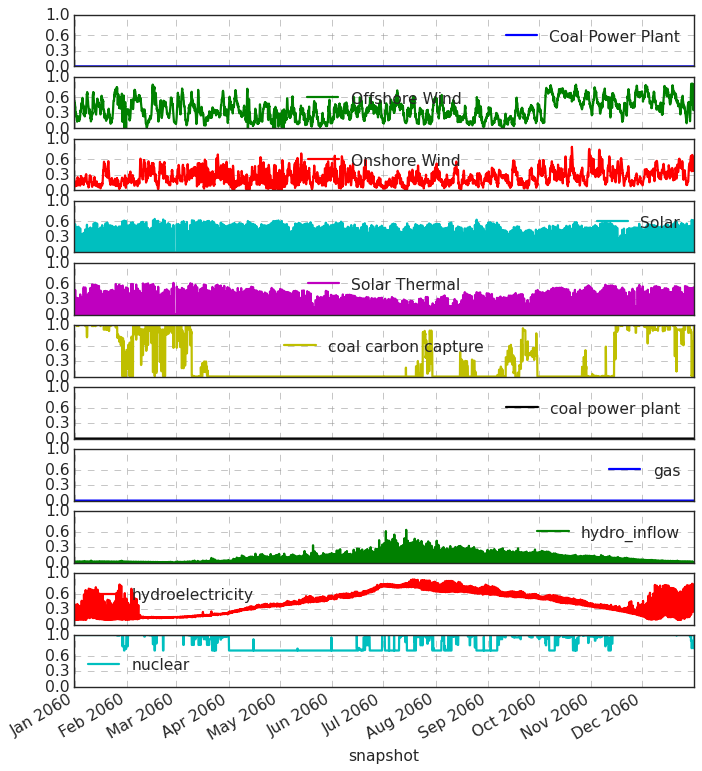

In [63]:
axes = capacity_factors.dropna(axis=1, how="all").fillna(0).plot(subplots=True, figsize=(10,12))
for ax in axes:
    ax.set_ylim([0,1])
    ax.set_yticks([0,0.3, 0.6,1])

In [123]:
capacity_factors["Onshore Wind"].mean(), capacity_factors["Offshore Wind"].mean(),  capacity_factors["Solar"].mean()

(0.2657091513549844, 0.3717660335218757, 0.2499530087069725)

In [ ]:

weighted_prices = pd.DataFrame(index=  pd.Index(
    [
        "electricity",
        "heat",
        "space heat",
        "urban heat",
        "space urban heat",
        "gas",
        "H2",
    ]
)
)

link_loads = {
"electricity": [
    "heat pump",
    "resistive heater",
    "battery charger",
    "H2 Electrolysis",
],
"heat": ["water tanks charger"],
"urban heat": ["water tanks charger"],
"space heat": [],
"space urban heat": [],
"gas": ["OCGT", "gas boiler", "CHP electric", "CHP heat"],
"H2": ["Sabatier", "H2 Fuel Cell"],
"CO2":[]

}

# busses are defined by "region subcarrer", where for AC subcarrier is empty
bus_suffixes = n.buses.index.str.split(" ", expand=True, n=1).droplevel(0).fillna("").unique()

for carrier in link_loads:
    if carrier == "electricity":
        suffix = ""
    elif carrier[:5] == "space":
        suffix = carrier[5:]
    else:
        suffix = " " + carrier

    buses = n.buses.index[n.buses.index.str[2:] == suffix]

    if buses.empty:
        continue

    # TODO fix undefined heat_demand_df
    if carrier in ["H2", "gas"]:
        load = pd.DataFrame(index=n.snapshots, columns=buses, data=0.0)
    else:
        load = n.loads_t.p_set[buses]

    for tech in link_loads[carrier]:
        names = n.links.index[n.links.index.to_series().str[-len(tech) :] == tech]

        if names.empty:
            continue

        load += n.links_t.p0[names].groupby(n.links.loc[names, "bus0"], axis=1).sum()

    # Add H2 Store when charging
    # if carrier == "H2":
    #    stores = n.stores_t.p[buses+ " Store"].groupby(n.stores.loc[buses+ " Store", "bus"],axis=1).sum(axis=1)
    #    stores[stores > 0.] = 0.
    #    load += -stores

    weighted_prices.loc[carrier, label] = (
        load * n.buses_t.marginal_price[buses]
    ).sum().sum() / load.sum().sum()

    # still have no idea what this is for, only for debug reasons.
    if carrier[:5] == "space":
        logger.debug(load * n.buses_t.marginal_price[buses])


In [208]:
n.statistics.supply(groupby=pypsa.statistics.get_bus_and_carrier, comps = ["Generator"])

component  bus                      carrier            
Generator  Ahai station             hydro_inflow           6.977094e+06
           Anhui                    Onshore Wind           3.069289e+01
                                    Solar                  1.984680e+08
                                    coal carbon capture    2.601212e+07
                                    hydroelectricity       1.783658e+07
                                                               ...     
           Zhejiang                 nuclear                7.046854e+07
           Zhejiang central heat    Solar Thermal          2.162749e+01
           Zhejiang coal            Coal Power Plant       1.130069e+05
           Zhejiang decentral heat  Solar Thermal          6.877480e+00
           Zhejiang gas             gas                    4.088148e+04
Name: generators, Length: 290, dtype: float64

In [209]:
n.statistics.withdrawal()

component    carrier             
Link         AC                      1.081164e+10
             Battery Storage         5.707120e+09
             CHP coal                2.254889e+03
             CHP gas                 5.362676e+06
             CO2 capture             3.295686e+08
             H2 CHP                  6.288915e+08
             Heat Pump               1.366266e+09
             Hydrogen Storage        2.497140e+09
             OCGT gas                9.010512e+07
             Sabatier                1.809132e+03
             battery discharger      5.591813e+09
             biomass                 9.944686e+08
             coal boiler             4.766809e+08
             gas boiler              4.315039e+08
             hydroelectricity        5.021273e+08
             resistive heater        1.111671e+09
             stations                1.512639e+08
             water tanks             3.079125e+09
Load         -                       2.274790e+10
StorageUnit  Pum

In [217]:
n.statistics.revenue()

component    carrier             
Link         AC                      5.483754e+10
             Battery Storage         1.403745e+09
             CHP coal                3.637641e+03
             CHP gas                 1.210990e+08
             CO2 capture             1.120154e+10
             H2 CHP                  1.200079e+10
             Heat Pump               6.008244e+10
             Hydrogen Storage        5.237764e+09
             OCGT gas                1.786557e+09
             Sabatier                4.890945e+04
             battery discharger      1.033561e+10
             biomass                 2.932666e+10
             coal boiler             7.664073e+08
             gas boiler              6.762261e+09
             hydroelectricity        1.021397e+10
             resistive heater        5.241573e+09
             stations               -1.729911e+04
             water tanks             2.021926e+08
Generator    Coal Power Plant        3.050770e+10
             Off

In [219]:
n.statistics.supply(
        groupby=pypsa.statistics.get_bus_and_carrier, bus_carrier="AC", comps=["Generator"]
    )

component  bus       carrier            
Generator  Anhui     Onshore Wind           3.069289e+01
                     Solar                  1.984680e+08
                     coal carbon capture    2.601212e+07
                     hydroelectricity       1.783658e+07
           Beijing   Onshore Wind           5.724700e+00
                                                ...     
           Zhejiang  Onshore Wind           1.049027e+08
                     Solar                  1.206871e+08
                     coal carbon capture    4.058045e+06
                     hydroelectricity       4.406669e+07
                     nuclear                7.046854e+07
Name: generators, Length: 143, dtype: float64

In [220]:
from _plot_utilities import assign_location
assign_location(n)

In [228]:
(n.statistics.revenue(groupby=[ "carrier"], comps= ["Load"])/n.statistics.withdrawal(groupby=[ "carrier"], comps= ["Load"])*-1).dropna()

component  carrier
Load                  37.79725
Name: objective, dtype: float64

In [222]:
n.statistics.revenue(groupby=pypsa.statistics.get_bus_and_carrier)

component  bus                             carrier         
Link       Ahai station                    hydroelectricity   -5.439028e+08
                                           stations           -3.184000e+06
           Anhui                           AC                  1.485842e+10
                                           Battery Storage    -1.620016e+09
                                           CHP coal            4.666915e+03
                                                                   ...     
Store      Zhejiang H2                     Hydrogen Storage    3.842495e+03
           Zhejiang battery                Battery Storage     2.957342e+08
           Zhejiang biomass                biomass             4.380748e+08
           Zhejiang central water tanks    water tanks         7.354561e+06
           Zhejiang decentral water tanks  water tanks         1.896111e+06
Length: 2085, dtype: float64

In [ ]:
n.statistics.revenue()/n.statistics.withdrawal()

component    carrier             
Generator    Coal Power Plant               NaN
             Offshore Wind                  NaN
             Onshore Wind                   NaN
             Solar                          NaN
             Solar Thermal                  NaN
             coal carbon capture            NaN
             coal power plant               NaN
             gas                            NaN
             hydro_inflow                   NaN
             hydroelectricity               NaN
             nuclear                        NaN
Link         AC                        5.072082
             Battery Storage           0.245964
             CHP coal                  1.613224
             CHP gas                  22.581825
             CO2 capture              33.988505
             H2 CHP                   19.082456
             Heat Pump                43.975650
             Hydrogen Storage          2.097505
             OCGT gas                 19.827480
      

In [197]:
n.statistics.market_value()

component    carrier             
Generator    Coal Power Plant        63.999962
             Offshore Wind           36.631181
             Onshore Wind            24.139481
             Solar                   22.494960
             Solar Thermal            9.027276
             coal carbon capture     88.118934
             coal power plant        43.701754
             gas                     51.999999
             hydro_inflow            23.635226
             hydroelectricity        30.714968
             nuclear                 43.263793
Link         AC                       5.271776
             Battery Storage          0.251036
             CHP coal                 2.027934
             CHP gas                 31.424419
             CO2 capture             36.457147
             H2 CHP                  21.202729
             Heat Pump               12.336994
             Hydrogen Storage         2.262427
             OCGT gas                46.110419
             Sabatier     

In [195]:
buses = n.buses.copy()
buses["carrier_suffix"] = n.buses.index.str.split(" ", expand=True, n=1).droplevel(0).fillna("")
load_suffixes = n.loads_t.p.columns.str.split(" ", n =1, expand=True).droplevel(0).fillna("").unique()
for name, g in buses.groupby("carrier_suffix"):
    # for some carrier the consumption is defined at the load level
    if name in load_suffixes:
        print(name)
    # for the rest, need to get it from link conversion
    else:


central heat
decentral heat


In [ ]:
buses = n.buses.copy()
buses["suffix"] = n.buses.index.str.split(" ", expand=True, n=1).droplevel(0).fillna("")
bus_suffixes = n.buses.index.str.split(" ", expand=True, n=1).droplevel(0).fillna("").unique()
for subcarrier in bus_suffixes:
    load_c =  n.loads_t[]

In [180]:
(n.loads_t.p- n.loads_t.p_set   ).abs().max().max()

0.0

In [157]:
n.buses[n.buses.index.str.contains(' battery')]

v_nom type           x          y  carrier unit  \
Bus                                                                      
Anhui battery            1.0       117.230646  31.801265  battery        
Beijing battery          1.0       116.409742  40.182049  battery        
Chongqing battery        1.0       107.869732  30.045894  battery        
Fujian battery           1.0       117.986925  26.067815  battery        
Gansu battery            1.0       101.052660  37.687476  battery        
Guangdong battery        1.0       113.406995  23.322145  battery        
Guangxi battery          1.0       108.785394  23.813227  battery        
Guizhou battery          1.0       106.870813  26.801620  battery        
Hainan battery           1.0       109.745154  19.193636  battery        
Hebei battery            1.0       116.115751  39.490397  battery        
Heilongjiang battery     1.0       127.859940  47.676472  battery        
Henan battery            1.0       113.613967  33.861889  battery        
Hubei battery            1.0       112.273093  30.962758  battery        
Hunan battery            1.0       111.710893  27.584739  battery        
InnerMongolia battery    1.0       113.547857  43.732355  battery        
Jiangsu battery          1.0       119.463108  32.953964  battery        
Jiangxi battery          1.0       115.715334  27.589514  battery        
Jilin battery            1.0       126.216895  43.631440  battery        
Liaoning battery         1.0       122.603965  41.280699  battery        
Ningxia battery          1.0       106.163222  37.253137  battery        
Qinghai battery          1.0        96.003446  35.690332  battery        
Shaanxi battery          1.0       108.858038  35.125259  battery        
Shandong battery         1.0       118.143729  36.336779  battery        
Shanghai battery         1.0       121.454525  31.195374  battery        
Shanxi battery           1.0       112.283249  37.531074  battery        
Sichuan battery          1.0       102.710793  30.568990  battery        
Tianjin battery          1.0       117.332651  39.307037  battery        
Tibet battery            1.0        88.176628  31.624005  battery        
Xinjiang battery         1.0        85.103781  40.868646  battery        
Yunnan battery           1.0       101.492257  24.940718  battery        
Zhejiang battery         1.0       120.087637  29.167873  battery        

                       v_mag_pu_set  v_mag_pu_min  v_mag_pu_max control  \
Bus                                                                       
Anhui battery                   1.0           0.0           inf      PQ   
Beijing battery                 1.0           0.0           inf      PQ   
Chongqing battery               1.0           0.0           inf      PQ   
Fujian battery                  1.0           0.0           inf      PQ   
Gansu battery                   1.0           0.0           inf      PQ   
Guangdong battery               1.0           0.0           inf      PQ   
Guangxi battery                 1.0           0.0           inf      PQ   
Guizhou battery                 1.0           0.0           inf      PQ   
Hainan battery                  1.0           0.0           inf      PQ   
Hebei battery                   1.0           0.0           inf      PQ   
Heilongjiang battery            1.0           0.0           inf      PQ   
Henan battery                   1.0           0.0           inf      PQ   
Hubei battery                   1.0           0.0           inf      PQ   
Hunan battery                   1.0           0.0           inf      PQ   
InnerMongolia battery           1.0           0.0           inf      PQ   
Jiangsu battery                 1.0           0.0           inf      PQ   
Jiangxi battery                 1.0           0.0           inf      PQ   
Jilin battery                   1.0           0.0           inf      PQ   
Liaoning battery                1.0           0.0           inf      PQ   
Ningx

# Pypsa eur

# Plot time series (dev sandbox)

Text(0, 0.5, 'GW')

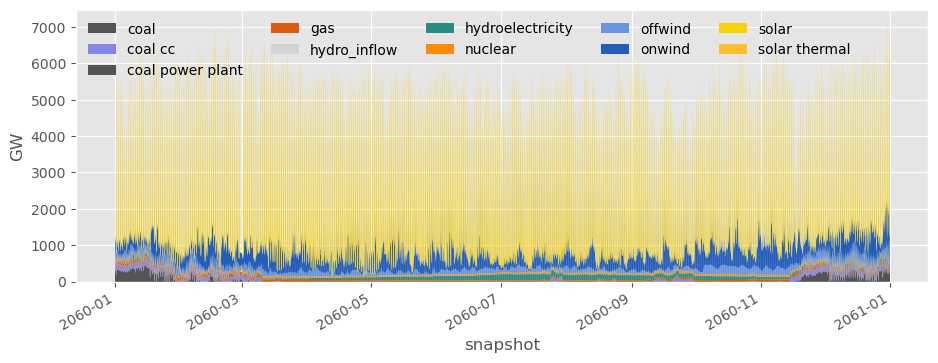

In [ ]:
p_by_carrier = n.generators_t.p.T.groupby(n.generators.carrier).sum().T.div(1e3)
fig, ax = plt.subplots(figsize=(11, 4))

p_by_carrier.plot(
    kind="area",
    ax=ax,
    linewidth=0,
    # cmap="tab20b",
    color = p_by_carrier.columns.map(n.carriers.color),
)

ax.legend(ncol=5, loc="upper left", frameon=False)

ax.set_ylabel("GW")

# ax.set_ylim(0, 80);

# COSTS

In [ ]:
# from plot_summary_all import plot_pathway_costs
# data_paths = {
#     "energy": [os.path.join(p, "energy.csv") for p in paths],
#     "costs": [os.path.join(p, "costs.csv") for p in paths],
#     "co2_price": [os.path.join(p, "metrics.csv") for p in paths],
#     "prices": [os.path.join(p, "prices.csv") for p in paths],
# }
# plot_pathway_costs(data_paths["costs"], config["plotting"], fig_name=None)

# STATS

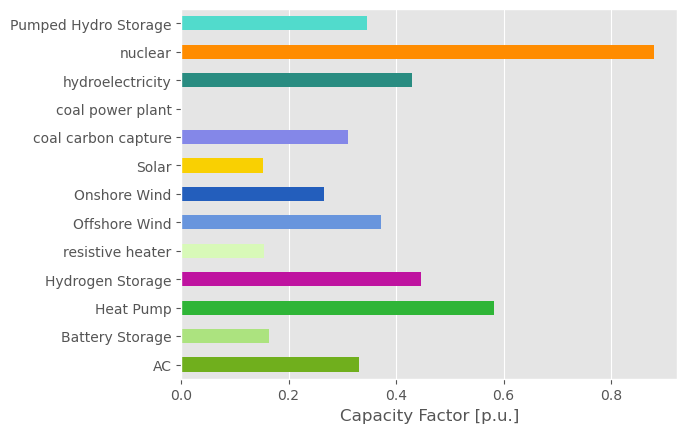

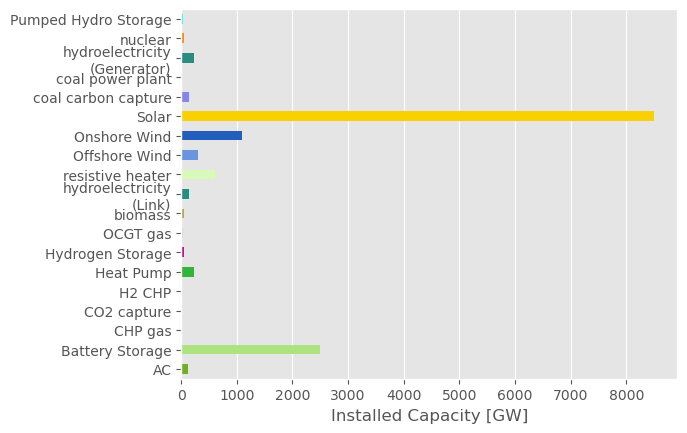

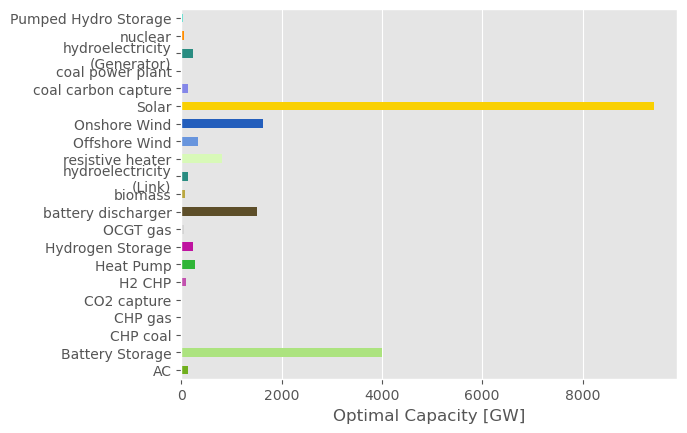

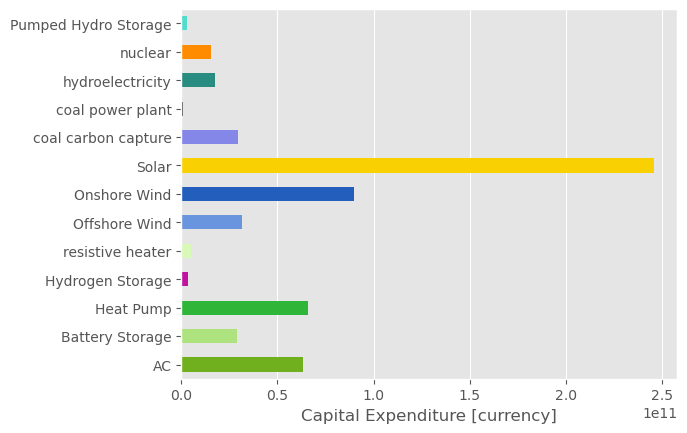

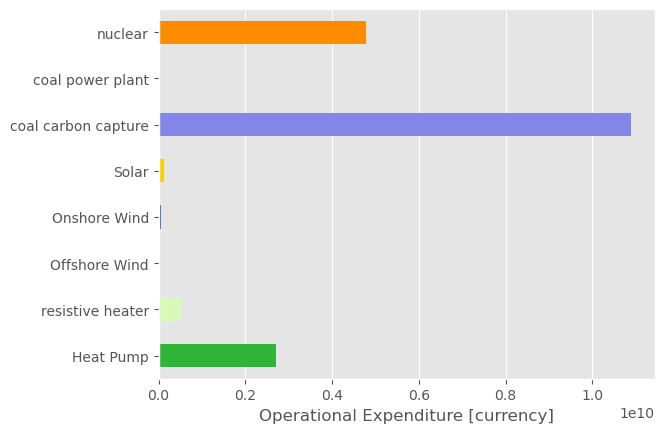

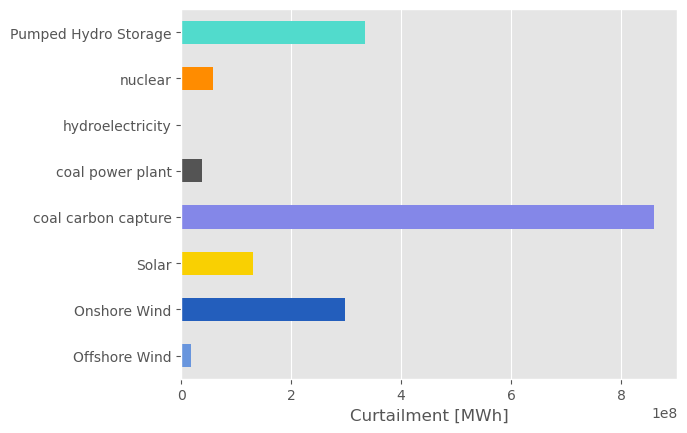

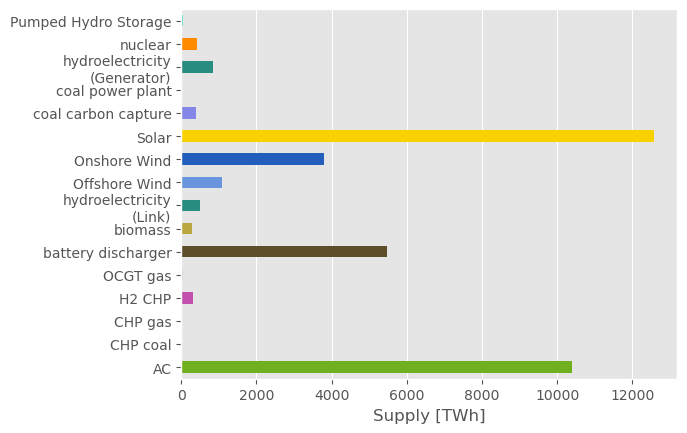

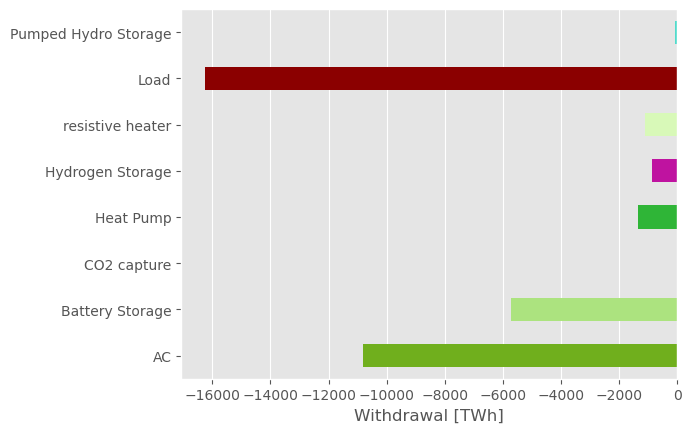

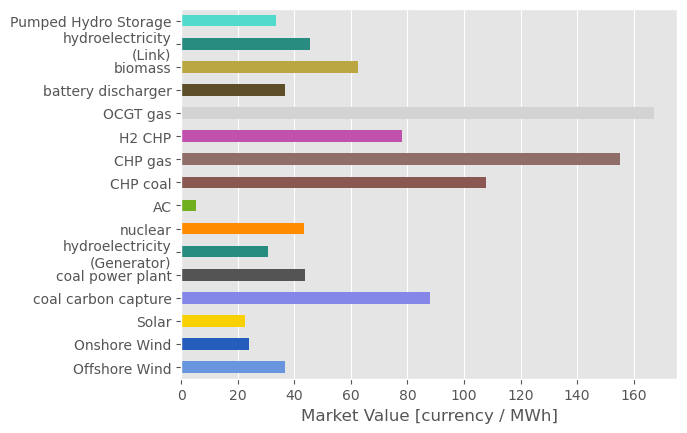

In [ ]:
bus_carrier = "AC"
n.loads.carrier = "load"
n.carriers.loc["load", ["nice_name", "color"]] = "Load", "darkred"
colors = n.carriers.set_index("nice_name").color.where(
    lambda s: s != "", "lightgrey"
)

def rename_index(ds):
    specific = ds.index.map(lambda x: f"{x[1]}\n({x[0]})")
    generic = ds.index.get_level_values("carrier")
    duplicated = generic.duplicated(keep=False)
    index = specific.where(duplicated, generic)
    return ds.set_axis(index)

def plot_static_per_carrier(ds, ax, drop_zero=True):
    if drop_zero:
        ds = ds[ds != 0]
    ds = ds.dropna()
    c = colors[ds.index.get_level_values("carrier")]
    ds = ds.pipe(rename_index)
    label = f"{ds.attrs['name']} [{ds.attrs['unit']}]"
    ds.plot.barh(color=c.values, xlabel=label, ax=ax)
    ax.grid(axis="y")

fig, ax = plt.subplots()
ds = n.statistics.capacity_factor(bus_carrier=bus_carrier).dropna()
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.installed_capacity(bus_carrier=bus_carrier).dropna()
if "Line" in ds.index:
    ds = ds.drop("Line")
ds = ds.drop(("Generator", "Load"), errors="ignore")
ds = ds / 1e3
ds.attrs["unit"] = "GW"
plot_static_per_carrier(ds.abs(), ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.optimal_capacity(bus_carrier=bus_carrier)
if "Line" in ds.index:
    ds = ds.drop("Line")
ds = ds.drop(("Generator", "Load"), errors="ignore")
ds = ds.abs() / 1e3
ds.attrs["unit"] = "GW"
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.capex(bus_carrier=bus_carrier)
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.opex(bus_carrier=bus_carrier)
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.curtailment(bus_carrier=bus_carrier)
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.supply(bus_carrier=bus_carrier)
if "Line" in ds.index:
    ds = ds.drop("Line")
ds = ds / 1e6
ds.attrs["unit"] = "TWh"
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.withdrawal(bus_carrier=bus_carrier)
if "Line" in ds.index:
    ds = ds.drop("Line")
ds = ds / -1e6
ds.attrs["unit"] = "TWh"
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.market_value(bus_carrier=bus_carrier)
plot_static_per_carrier(ds, ax)
plt.show()

In [112]:
np.unique(n.get_switchable_as_dense("Generator", "p_max_pu").values)

array([0.        , 0.01000001, 0.01000018, ..., 0.99999408, 1.        ,
       1.        ])

In [114]:
c = "Generator"
p = (
    n.get_switchable_as_dense(c, "p_max_pu") * n.static(c).p_nom_opt
    - n.dynamic(c).p
).clip(lower=0)
p.T.groupby(n.generators.carrier).sum()

snapshot          2059-12-31 16:00:00  2059-12-31 17:00:00  \
carrier                                                      
coal                     3.099696e+09         3.099697e+09   
coal cc                  2.697716e-01         2.709262e-01   
coal power plant         4.228162e+03         4.228162e+03   
gas                      3.099916e+09         3.099916e+09   
hydro_inflow             6.347386e-08         0.000000e+00   
hydroelectricity         2.696607e-02         2.698062e-02   
nuclear                  2.668372e-02         2.660656e-02   
offwind                  2.479869e-02         2.456456e-02   
onwind                   6.293101e-02         6.150938e-02   
solar                    0.000000e+00         0.000000e+00   
solar thermal            0.000000e+00         0.000000e+00   

snapshot          2059-12-31 18:00:00  2059-12-31 19:00:00  \
carrier                                                      
coal                     3.099690e+09         3.099680e+09   
coal cc                  2.711296e-01         2.712790e-01   
coal power plant         4.228162e+03         4.228162e+03   
gas                      3.099916e+09         3.099916e+09   
hydro_inflow             0.000000e+00         0.000000e+00   
hydroelectricity         2.697644e-02         2.697248e-02   
nuclear                  2.651113e-02         2.648689e-02   
offwind                  2.459569e-02         2.450372e-02   
onwind                   6.048886e-02         5.956184e-02   
solar                    0.000000e+00         0.000000e+00   
solar thermal            0.000000e+00         0.000000e+00   

snapshot          2059-12-31 20:00:00  2059-12-31 21:00:00  \
carrier                                                      
coal                     3.099663e+09         3.099624e+09   
coal cc                  2.713587e-01         2.712299e-01   
coal power plant         4.228162e+03         4.228162e+03   
gas                      3.099916e+09         3.099916e+09   
hydro_inflow             0.000000e+00         0.000000e+00   
hydroelectricity         2.697284e-02         2.701281e-02   
nuclear                  2.649318e-02         2.642753e-02   
offwind                  2.426292e-02         2.418479e-02   
onwind                   5.865124e-02         5.799126e-02   
solar                    0.000000e+00         0.000000e+00   
solar thermal            0.000000e+00         0.000000e+00   

snapshot          2059-12-31 22:00:00  2059-12-31 23:00:00  \
carrier                                                      
coal                     3.099526e+09         3.099494e+09   
coal cc                  2.705738e-01         2.703051e-01   
coal power plant         4.228162e+03         4.228162e+03   
gas                      3.099916e+09         3.099916e+09   
hydro_inflow             0.000000e+00         0.000000e+00   
hydroelectricity         2.721279e-02         2.758712e-02   
nuclear                  2.640434e-02         2.640763e-02   
offwind                  2.300910e-02         2.276314e-02   
onwind                   5.689607e-02         5.591770e-02   
solar                    0.000000e+00         0.000000e+00   
solar thermal            0.000000e+00         0.000000e+00   

snapshot          2060-01-01 00:00:00  2060-01-01 01:00:00  ...  \
carrier                                                     ...   
coal                     3.099531e+09         3.099609e+09  ...   
coal cc                  2.703679e-01         2.731344e-01  ...   
coal power plant         4.228162e+03         4.228162e+03  ...   
gas                      3.099916e+09         3.099916e+09  ...   
hydro_inflow             0.000000e+00         0.000000e+00  ...   
hydroelectricity         2.745948e-02         2.721704e-02  ...   
nuclear                  2.631040e-02         2.656488e-02  ...   
offwind                  2.255952e-02         2.233788e-02  ...   
onwind                   5.368603e-02         5.314116e-02  ...   
solar                    7.917243e-

In [72]:
carrier = "onwind"
p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum()
p_by_carrier.drop(
    (p_by_carrier.max()[p_by_carrier.max() < 1700.0]).index, axis=1, inplace=True
)
p_by_carrier.columns
capacity = n.generators.groupby("carrier").sum()[ "p_nom"]
p_available = n.generators_t.p_max_pu.multiply(n.generators["p_nom"])
p_available_by_carrier = p_available.groupby(n.generators.carrier, axis=1).sum()
p_curtailed_by_carrier = p_available_by_carrier - p_by_carrier

/tmp/ipykernel_12268/300108380.py:2: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

/tmp/ipykernel_12268/300108380.py:9: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



In [ ]:
p_curtailed_by_carrier.plot()

In [95]:
tcs = config["plotting"]["tech_colors"]
tcs.update({"solar thermal": "magenta"})

<Axes: xlabel='snapshot'>

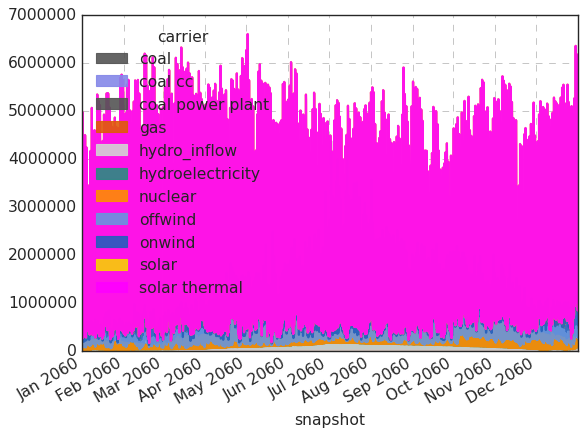

In [96]:
colors = p_available_by_carrier.columns.map(tcs).fillna("lightgrey")
colors
p_available_by_carrier.plot(alpha=0.9, kind = "area", stacked=True, color=colors)

<Axes: xlabel='snapshot'>

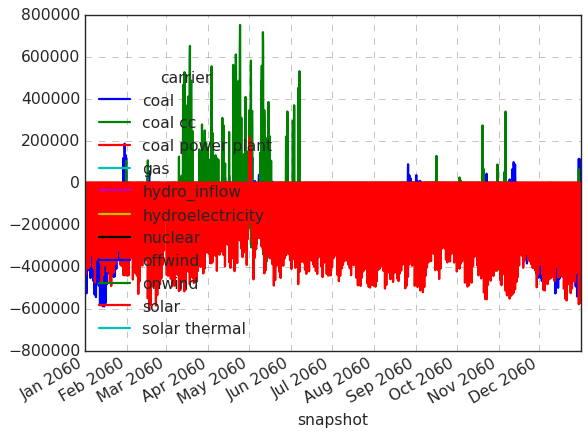

In [73]:
p_curtailed_by_carrier.plot()

In [98]:

p_by_carrier = n.generators_t.p.T.groupby(n.generators.carrier).sum().T
p_by_carrier.drop(
    (p_by_carrier.max()[p_by_carrier.max() < 100]).index, axis=1, inplace=True
)

capacity = n.generators.groupby("carrier").sum()[ "p_nom_opt"]
p_available = n.generators_t.p_max_pu.multiply(n.generators["p_nom_opt"])
p_available_by_carrier = p_available.groupby(n.generators.carrier, axis=1).sum()
p_curtailed_by_carrier = p_available_by_carrier - p_by_carrier

/tmp/ipykernel_12268/2904338300.py:8: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



In [106]:
p_available_by_carrier

carrier              coal  coal cc  coal power plant  gas   hydro_inflow  \
snapshot                                                                   
2059-12-31 16:00:00   0.0      0.0               0.0  0.0  143632.481534   
2059-12-31 17:00:00   0.0      0.0               0.0  0.0       0.000000   
2059-12-31 18:00:00   0.0      0.0               0.0  0.0       0.000000   
2059-12-31 19:00:00   0.0      0.0               0.0  0.0       0.000000   
2059-12-31 20:00:00   0.0      0.0               0.0  0.0       0.000000   
...                   ...      ...               ...  ...            ...   
2060-12-31 11:00:00   0.0      0.0               0.0  0.0       0.000000   
2060-12-31 12:00:00   0.0      0.0               0.0  0.0       0.000000   
2060-12-31 13:00:00   0.0      0.0               0.0  0.0       0.000000   
2060-12-31 14:00:00   0.0      0.0               0.0  0.0       0.000000   
2060-12-31 15:00:00   0.0      0.0               0.0  0.0       0.000000   

carrier              hydroelectricity  nuclear        offwind         onwind  \
snapshot                                                                       
2059-12-31 16:00:00      24420.704383      0.0  182914.219316  383957.723897   
2059-12-31 17:00:00      23361.292949      0.0  178301.308345  364927.715087   
2059-12-31 18:00:00      22873.195936      0.0  176397.932625  337222.992925   
2059-12-31 19:00:00      22471.573019      0.0  176716.189486  318491.335585   
2059-12-31 20:00:00      22264.711278      0.0  176421.904720  308488.047095   
...                               ...      ...            ...            ...   
2060-12-31 11:00:00     175525.297767      0.0  203069.550988  764157.119914   
2060-12-31 12:00:00     174848.531979      0.0  200518.667615  807457.728327   
2060-12-31 13:00:00     168112.737553      0.0  196511.008923  823093.095137   
2060-12-31 14:00:00     157689.834433      0.0  191496.787037  816534.621122   
2060-12-31 15:00:00     129431.496384      0.0  190609.134624  784793.641391   

carrier                      solar  solar thermal  
snapshot                                           
2059-12-31 16:00:00       0.000000       0.000000  
2059-12-31 17:00:00       0.000000       0.000000  
2059-12-31 18:00:00       0.000000       0.000000  
2059-12-31 19:00:00       0.000000       0.000000  
2059-12-31 20:00:00       0.000000       0.000000  
...                            ...            ...  
2060-12-31 11:00:00  115464.716037      29.250695  
2060-12-31 12:00:00       0.000000       0.000000  
2060-12-31 13:00:00       0.000000       0.000000  
2060-12-31 14:00:00       0.000000       0.000000  
2060-12-31 15:00:00       0.000000       0.000000  

[8760 rows x 11 columns]

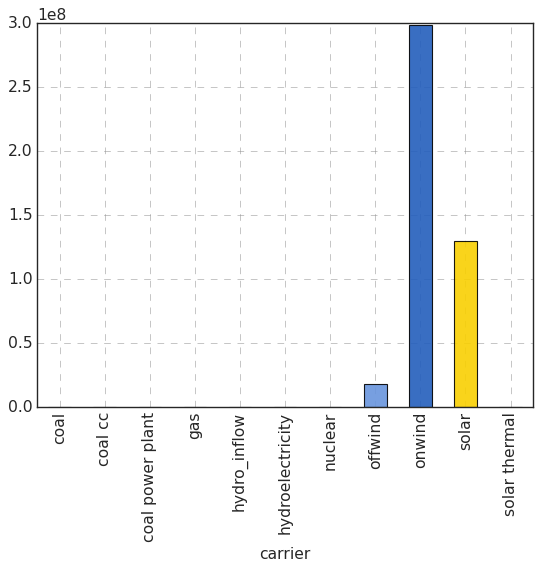

In [116]:
tcs = config["plotting"]["tech_colors"]
tcs.update({"solar thermal": "magenta"})
colors = p_available_by_carrier.columns.map(tcs).fillna("lightgrey")
colors
axes = p_curtailed_by_carrier.clip(0).sum().plot(alpha=0.9, color=colors, kind = "bar")

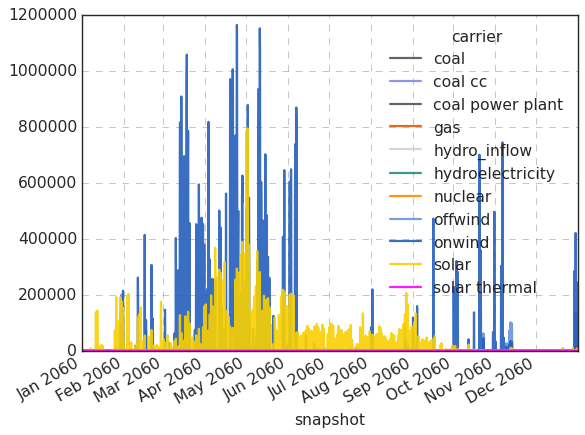

In [115]:
colors = p_available_by_carrier.columns.map(tcs).fillna("lightgrey")
colors
axes = p_curtailed_by_carrier.clip(0).plot(alpha=0.9, color=colors)

In [ ]:
ds = n.statistics.installed_capacity(bus_carrier=bus_carrier).dropna()

ds = ds[ds != 0]
ds = ds.dropna()
c = colors[ds.index.get_level_values("carrier")]
# ds = ds.pipe(rename_index)
# label = f"{ds.attrs['name']} [{ds.attrs['unit']}]"
# ds.plot.barh(color=c.values, xlabel=label, ax=ax)
# ax.grid(axis="y")
ds

component    carrier             
Link         AC                     -1.183159e+05
             Battery Storage        -2.491807e+06
             CHP gas                 2.919169e+03
             CO2 capture            -1.120715e+03
             H2 CHP                  1.783871e+04
             Heat Pump              -2.375537e+05
             Hydrogen Storage       -5.709651e+04
             OCGT gas                3.038034e+04
             biomass                 5.441094e+04
             hydroelectricity        1.403220e+05
             resistive heater       -6.141324e+05
Generator    Offshore Wind           3.098862e+05
             Onshore Wind            1.088312e+06
             Solar                   8.491308e+06
             coal carbon capture     1.421236e+05
             coal power plant        4.228163e+03
             hydroelectricity        2.253780e+05
             nuclear                 5.464700e+04
StorageUnit  Pumped Hydro Storage    3.639000e+04
dtype: float64

# Network topology

In [ ]:
n.determine_network_topology()
n.sub_networks["n_branches"] = [
    len(sn.branches()) for sn in n.sub_networks.obj
]
n.sub_networks["n_buses"] = [len(sn.buses()) for sn in n.sub_networks.obj]

n.sub_networks



carrier         slack_bus  \
SubNetwork                              
0                AC             Anhui   
1                AC           Beijing   
2                AC         Chongqing   
3                AC            Fujian   
4                AC             Gansu   
...             ...               ...   
410         battery   Tianjin battery   
411         battery     Tibet battery   
412         battery  Xinjiang battery   
413         battery    Yunnan battery   
414         battery  Zhejiang battery   

                                                          obj  n_branches  \
SubNetwork                                                                  
0           <pypsa.components.SubNetwork object at 0x7f9af...           0   
1           <pypsa.components.SubNetwork object at 0x7f9af...           0   
2           <pypsa.components.SubNetwork object at 0x7f9af...           0   
3           <pypsa.components.SubNetwork object at 0x7f9af...           0   
4           <pypsa.components.SubNetwork object at 0x7f9af...           0   
...                                                       ...         ...   
410         <pypsa.components.SubNetwork object at 0x7f9af...           0   
411         <pypsa.components.SubNetwork object at 0x7f9af...           0   
412         <pypsa.components.SubNetwork object at 0x7f9af...           0   
413         <pypsa.components.SubNetwork object at 0x7f9af...           0   
414         <pypsa.components.SubNetwork object at 0x7f9af...           0   

            n_buses  
SubNetwork           
0                 1  
1                 1  
2                 1  
3                 1  
4                 1  
...             ...  
410               1  
411               1  
412               1  
413               1  
414               1  

[415 rows x 5 columns]

# EXAMPLES